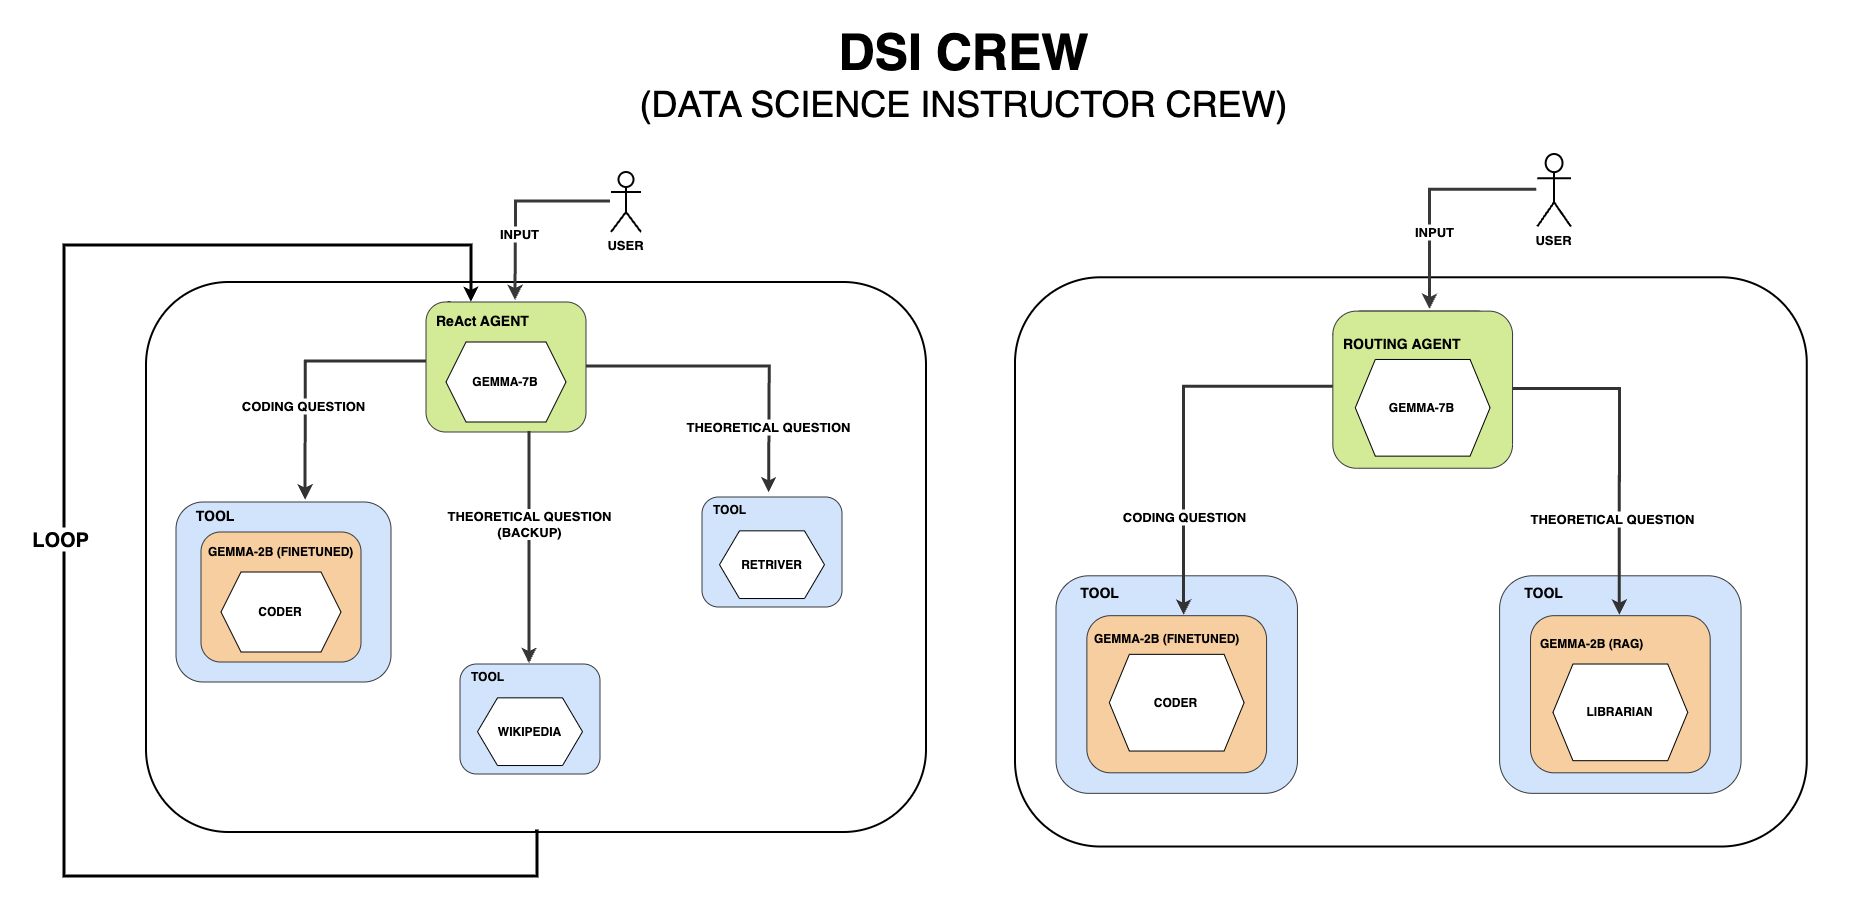

<br>

# Table of Contents
1. [Introduction](#1.)<br>
2. [Vanilly Gemma](#2.)<br>
&emsp;2.a [Understand Gemma Variants](#2.a)<br>
&emsp;2.b [Memory Requirement](#2.b)<br>
&emsp;2.c [Testing Gemma on Our Task](#2.c)<br>
&emsp;&emsp;&emsp;2.c1 [Comparing the Models And Choosing One ](#2.c1)<br>
&emsp;2.d [Quantization](#2.d)<br>
&emsp;2.e [Quiz 1](#2.e)<br>
&emsp;2.f [Key Takeaways](#2.f)<br>
3. [Creating the Coder: Fine-Tuning](#3.)<br>
&emsp;3.a [Parameter-Efficient Fine-Tuning (PEFT)](#3.a)<br>
&emsp;3.b [Fine-Tuning Gemma With QLoRA](#3.b)<br>
&emsp;3.c [Quiz 2](#3.c)<br>
&emsp;3.d [Key Takeaways](#3.d)<br>
4. [Building the Librarian: Retrieval-Augmented Generation (RAG)](#4.)<br>
&emsp;4.a [The Retriever](#4.a)<br>
&emsp;4.d [Key Takeaways](#4.d)<br>
5. [The Agent: Put it all together](#5.)<br>
&emsp;5.a [Gemma as A ReAct Agent](#5.a)<br>
&emsp;5.b [Gemma as A Routing Agent](#5.b)<br>
&emsp;&emsp;&emsp;5.b1 [Completing our RAG: The Generator](#5.b1)<br>
&emsp;5.d [Quiz 3](#5.d)<br>
&emsp;5.e [Key Takeaways](#5.e)<br>
6. [Demo](#6.)<br>
7. [Conclusion](#7.)<br>
8. [Your turn](#8.)<br>

<br>

# 1. Introduction <a id="1."></a>

<br>

**This is what we are going to build (UI code is provided as utility script):**



In [1]:
from IPython.display import display_html

display_html(
    """
    <iframe src="https://drive.google.com/file/d/10WrH8WAAVnGHq4W4qQ7c2AuqC8X7lUSg/preview" width="775" height="500" allow="autoplay" allowfullscreen></iframe>
    """,
    raw=True,
)

AI agents are everywhere these days! From chatbots that streamline customer service to virtual assistants that manage our schedules, these intelligent programs are revolutionizing how we interact with technology. If you're looking to join the forefront of innovation, learning to build AI agents is your ticket in.
    
In this tutorial we will use the example of building an AI Assistant that teaches basic Data Science concepts to explore different ways to adapt Gemma to your specific use-cases.
We will build the DSI Crew (Data Science Instructor Crew), which is a group of specialized LLMs orchestrated by an AI Agent all based on Gemma.
    
The goal of this tutorial is to teach you how to build powerfull AI-powered apps with Gemma using the example above. We will:
 - Start by learning what Gemma is, the compute and memory ressources required to run its 7b and 2b variants 
 - Then learn about quantization to see how we can load and perform inference on Gemma in resource restricted environments
 - Explore some fine-tuning techiques that we will them apply to Gemma 2B.
 - Continue with RAG
 - See what AI agents are and dive into the details of ReAct Agent
 - And then combine all of this to create a powerfull system orchestrated by a ReAct Agent
 
We will learn a lot of usefull concepts and techiques a long the way and talk about how and when each of these techiques should be used.
 
But before trying any of these methods, it's better to check what Gemma can do without any of them. Let's do that in the next section.
    
<br>
Let's start by installing some dependencies that we will use later.

In [1]:
!pip install \
git+https://github.com/huggingface/transformers.git \
git+https://github.com/huggingface/datasets.git \
git+https://github.com/huggingface/trl.git \
git+https://github.com/huggingface/peft.git \
git+https://github.com/huggingface/accelerate.git \
bitsandbytes \
ipywidgets

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-x1zlbrtz
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-x1zlbrtz
  Resolved https://github.com/huggingface/transformers.git to commit 60dea593edd0b94ee15dc3917900b26e3acfbbee
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/huggingface/datasets.git to /tmp/pip-req-build-uisqp49c
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/datasets.git /tmp/pip-req-build-uisqp49c
  Resolved https://github.com/huggingface/datasets.git to commit 0f1f27c69f6cc8d085b66a8a2ba0440a39bc5bce
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/huggingface/trl.git to /tmp/pip-req-build-35i8mse6
  

In [9]:
from transformers import set_seed

# Random number generators seed for reproducibility (same code == same results)
# Set the seed in random, numpy, torch and/or tensorflow (if installed)
set_seed(22)



# 2. Vanilly Gemma <a id="2."></a>
    
Gemma LLM is a family of open-source large language models (LLMs) created by Google DeepMind.  Think of it as a powerful tool for developers and researchers to experiment with AI in a responsible way. Here are the key things to know about Gemma:

* **Open-source:** Anyone can access and use Gemma.
* **Multiple Sizes:**  Gemma comes in two sizes, 2B and 7B parameters, making it flexible for different computing needs.  The smaller size can even run on laptops and mobile devices!
* **Pre-trained and Fine-tuned:** Gemma offers both pre-trained models for general use and fine-tuned versions optimized for instruction following and task execution.
 
    
## 2.a Understand Gemma Variants <a id="2.a"></a>

<br>

| **Name** | **Parameters** | **Type** | **Chat Freindly** | **TruthfulQA** | **MMLU** | **HellaSwag** | **GSM8K** |
|:-|---|---|---|---|---|---|---|
| gemma-2b | 2 Billion | Pretrained | No | 33.13 | 41.68 | 71.65 | 17.36 |
| gemma-2b-it | 2 Billion | Instruction tuned | Yes | 45.82 | 37.65 | 45.82 | 37.65 |
| gemma-7b | 7 Billion | Pretrained | No | 44.91 | 66.03 | 82.47 | 52.77 |
| gemma-7b-it | 7 Billion | Instruction tuned | Yes | 47.29 | 53.52 | 71.96 | 29.19|

<br>
<p class="alert alert-block alert-info"><b>Note:</b> If you don't know what a <a href="https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html">token</a> is, think of it as word for simplicity. I may use "token" and "word" interchangeably in some cases</p>
    
In theory, the bigger a model the better it performs, so the 7 billion models will most likely perform better at many tasks(more about this later). The inner working of LLMs(Large Language Models) is behond the scope of this tutorial, but let me give you simple high level explaination so that you can understand the difference between the instruction tuned and the pretrained models.
The way LLMs are trained to understand Natural Language is by teaching them to predict the next token token of a sequence, at the end of the training, they can only predict the next token given a sequence. This process is called **pretraining**. If you give them instructions at this stage, they will output something that is more likly to be a continuation of the prompt you provided but the won't be able to understand and execute instructions like Gemini and ChatGPT do. To be able to do that, they need to be further trained (fine-tuned), this time the learning objectif not being to predict the next word but to receive instructions as prompt, and execute them. This process is called **instruction fine-tuning**. Basicaly gemma-2b-it is gemma-2b that has been instruction fine-tuned. And as you saw in the table above, the instruction fine-tuned gemma-2b-it is chat freindly (like ChatGPT and Gemini) while gemma-2b isn't. The same applies to gemma-7b and gemma-7b-it.

#### More about the benchmarks in the Table:
    
<b>TruthfulQA:</b><br>
Tests: Focuses on how truthful a large language model (LLM) is in its answers.<br>
Skills: Measures an LLM's ability to avoid biases or misleading information learned from its training data. It also discourages simply saying "I don't know" for every question.<br>
Example: Imagine TruthfulQA asks, "Who created Gemma?" An ideal answer would be "Google" without any fictional details.<br>

<b>MMLU (Massive Multitask Language Understanding):</b><br>
Tests: Broad understanding and application of knowledge across various subjects.<br>
Skills: Evaluates an LLM's ability to handle a wide range of tasks, including answering questions from history, science, law, and even basic math. It assesses problem-solving using acquired knowledge.<br>
Example: MMLU might ask, "If a train travels 100 miles at 50 miles per hour, how long will the journey take?" Here, the LLM needs to understand the concept of speed and distance to solve the problem.<br>

<b>HellaSwag:</b><br>
Tests: Focuses on an LLM's ability to reason using common sense.<br>
Skills: Measures how well an LLM understands everyday situations and can complete sentences logically.<br>
Example: HellaSwag might present a prompt like "The cookies were left out all night, so they are probably..." with answer choices like "fresh" or "stale." An LLM that understands common sense would choose "stale."<br>

<b>GSM8K (Grade School Math 8K):</b><br>
Tests: Specifically targets an LLM's ability to solve multi-step math problems.<br>
Skills: Evaluates an LLM's competency in basic arithmetic operations (+, -, *, /) and applying them sequentially to solve word problems.<br>
Example: GSM8K might present a problem like "John has 5 apples and Mary has 3. How many apples do they have in total?" The LLM would need to perform addition to find the answer.<br>


## 2.b Memory Requirement <a id="2.b"></a>

When choosing a model, it is important to know some information like number of parameters, pretrained or instruction-tuned as well as how the model performs at some benchmarks depending on the task it will be used for.
One other important thing to check, is the amount of memory required to perform inference on the model. Let's see how much memory we need to load each of the Gemma models for inference using the transformer library.
    
Note: I created an [utility script](https://www.kaggle.com/code/sitaberete/utilty-scripts-for-build-ai-agents-with-gemma) that contains code for displaying plots, rendering quizzes and demos. You are not required to checkout that notebook or even understand the code. I created it simply to not put code that is irrelevant to what we are learning in this tutorial. We will import the script in the next cell. From there, if you see a code like `utils.function_name()` you can ignore it.

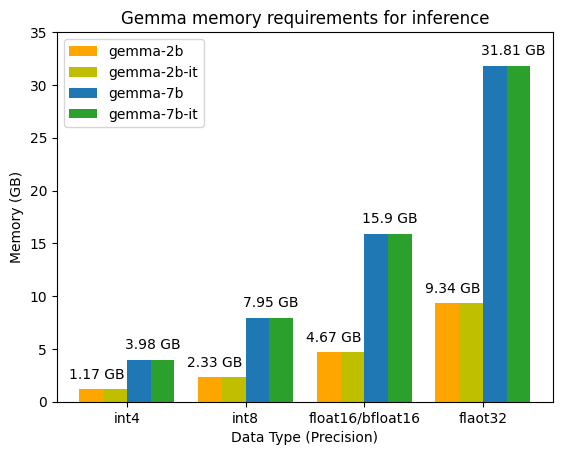

In [6]:
# Utility Code, You can ignore
import utilty_scripts_for_build_ai_agents_with_gemma as utils

utils.plot_memory_usage()

<p class="alert alert-block alert-info"><b>Note:</b> the memory requirements in the chart above are only for inference. If you want to train these models, you will need much more memory. For instance, to train the gemma-7b model with a bfloat precision using an Adam optimizer, you will need around 63.61 GB of memory. When it commes to fine-tuning, it depends on the method you use. You can check this amazing <a href="https://huggingface.co/spaces/hf-accelerate/model-memory-usage">Model Memory Calculator tool</a> from Hugging Face that works on any model hosted on their hub</p>

The Gemma models' weights are saved with the bfloat16 precision. Which means we are less likely to be able to load and run the 7B model on a 16 GB GPU like the T4 since some memory will be reserved as well depending on the framework you are using. Does this mean we can't perform inference on the 7B model on Kaggele? What are the `int4`,`int8`,`float16/bfloat16`,`flaot32`? Why do they have different memory requirements? We will answer to these questions when we talk about **quantization** later because for now, I can imagine some of you starting to think "When will we see some code?". So let's write some code!



## 2.c Testing Gemma on Our Task <a id="2.c"></a>    
    
There are many ways to access Gemma in your code, some of them are through [KerasNLP](https://keras.io/keras_nlp) or [🤗 Transformers](https://huggingface.co/docs/transformers/en/index). In this tutorial we will use Transformers. <br>
To access gemma models, you need to read and accept the licence terms. You can still use gemma model even in commercial application, as long as you respect the Licence terms. 

The following is optional. Do the following step only if you want to download the gemma models directly from hugging face or want to publish our fine-tuned model to their hub.
 
If you don't have access to Gemma on Hogging face yet, you can click on this link to access it https://huggingface.co/google/gemma-7b-it.<br>
Then you need a hogging face [access token](https://huggingface.co/docs/hub/security-tokens) and put that access token in an environment variable called `HF_TOKEN` so that you don't need to manually specify it everytime you want to download a gemma model using the Transformers library. You can also put the access token in [kaggle secrets](https://www.kaggle.com/discussions/product-feedback/114053) and access it like in the code below.

In [8]:
from kaggle_secrets import UserSecretsClient
import os

hugging_face_token = UserSecretsClient().get_secret("HuggingSecret")

os.environ['HF_TOKEN'] = hugging_face_token

Let's put the model ids in variables to easily access them later and create 3 prompts that we will use to test the models and see how each of them perform on the 3.

In [13]:
# TODO: Change to the new gemma 1.1 versions once they have been tested enough by the community
gemma_2b = '/kaggle/input/gemma/transformers/2b/2'
gemma_7b_it = '/kaggle/input/gemma/transformers/7b-it/3'
gemma_2b_it = '/kaggle/input/gemma/transformers/2b-it/3'

# Model IDs on Hugging Face Hub
#gemma_7b = 'google/gemma-7b'
#gemma_7b_it = 'google/gemma-7b-it'
#gemma_2b_it = 'google/gemma-2b-it'

# Test prompts
prompt_1 = "What is Data Science?"
prompt_2 = "Explain 3 important Data Science concepts, and tell why each concept is important"
prompt_3 = "I'm a psychology honours student, I know nothing about Data Science. Explain to me what Data Science is and simplifie it as much as you can. When possible, use analogies that I can understand better as a marketing specialist"
# These prompts are just a way to test our models and see how they perform depending on the amount of information they are given.

If you are thinking gemma_7b (pretrained) is missing, you are right. You will understand why in a moment.<br>
Let's create a function that will facilitate testing all the models above and observe their differences. This will help us choose the most apropriate one for our task.


In [16]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import gc


def run_inference(model_id, prompts):
    # Load the tokenizer and the model
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForCausalLM.from_pretrained(model_id, device_map='auto', torch_dtype=torch.float16)
    
    # Tokenize the prompts
    input_ids = tokenizer(prompts, padding=True, return_tensors='pt').to('cuda')
    
    # Generate ouputs and decode them
    outputs = model.generate(**input_ids, max_new_tokens=1024)
    output_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    
    # Clear GPU memeory to enable the next model to be loaded (We need this because we are testing multiple models)
    del model
    del tokenizer
    gc.collect()
    torch.cuda.empty_cache()
    
    return output_texts

<p class="alert alert-block alert-warning"><b>Warning:</b> I said earlier that default data type of the Gemma models is bfloat16, but I used float16 to load them above. This is because the T4 and P100 GPUs doesn't support the bfloat16, If you whant to use it add the following lines before calling <code>model.generate</code>:<br>
<code>torch.backends.cuda.enable_mem_efficient_sdp(False)<br>torch.backends.cuda.enable_flash_sdp(False)
</code>
Otherwise you will get this error <code>RuntimeError: cutlassF: no kernel found to launch!</code>
</p>

You may be able to run the following cell on a P100 16GB GPU (I was able to). But if you see an `OutOfMemoryError` error by running the cell, make sure that *GPU T4 x2* is selected as the accelerator if you are on Kaggle, if not, make sure your GPU has at least 17 GB of memory. If your are not on kaggle and you don't have anough memory, you can skip the cell and jump to the comparison of the results right after the cell. This is just needed for testing Gemma including 7B IT with float16 dtype and see how they perform without extrem quantization, so you can follow the rest of the tutorial on a 16 GB GPU like the T4 of P100.

In [24]:
output_2b_it = run_inference(gemma_2b_it, [prompt_1,prompt_2,prompt_3])
output_7b_it = run_inference(gemma_7b_it, [prompt_1,prompt_2,prompt_3])
output_2b = run_inference(gemma_2b, [prompt_1,prompt_2,prompt_3])

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### 2.c1 Comparing the Models And Choosing One <a id="2.c1"></a>

In [25]:
# Utility Code, You can ignore
outputs = [
    ('Gemma 7B Instriction Tuned Outputs', output_7b_it),
    ('Gemma 2B Instriction Tuned Outputs', output_2b_it), 
    ('Gemma 2B Pretrained Outputs', output_2b),
]
utils.display_formatted_models_comparaison_outputs(outputs)

Gemma 7B Instriction Tuned Outputs  

 
 
 What is Data Science? 
 Data science is the process of extracting insights from large amounts of data using various techniques and tools. It involves collecting, cleaning, analyzing, visualizing, and interpreting data to gain valuable knowledge and make informed decisions. Data science is a multidisciplinary field that draws on skills from statistics, computer science, data mining, and domain expertise. **Key Components of Data Science:** * **Data wrangling:** Collecting, cleaning, and transforming raw data into a usable format. * **Data analysis:** Exploring, summarizing, and analyzing data using statistical methods and data mining techniques. * **Data visualization:** Representing data in various formats, such as charts, graphs, and dashboards, to facilitate understanding. * **Model building:** Creating predictive models based on historical data to forecast future trends or make decisions. * **Model evaluation:** Assessing the accuracy and performance of models and refining them for improved accuracy. **Applications of Data Science:** * **Business intelligence:** Gaining insights into customer behavior, product performance, and market trends. * **Marketing:** Personalizing customer experiences and optimizing marketing campaigns. * **Healthcare:** Diagnosing diseases, predicting patient outcomes, and improving patient care. * **Science:** Understanding biological processes, uncovering new discoveries, and developing new technologies. * **Social good:** Addressing social challenges, improving governance, and promoting sustainability. **Tools and Technologies:** * **Programming languages:** Python, R, Java, SQL * **Data wrangling tools:** Pandas, Spark, Tableau * **Data visualization tools:** Matplotlib, Seaborn, Tableau * **Machine learning libraries:** scikit-learn, TensorFlow, PyTorch * **Big data platforms:** Hadoop, Spark, Hive **Conclusion:** Data science is a powerful tool for extracting insights from large amounts of data. It involves a wide range of techniques and tools and has applications in various fields. By understanding the key components and applications of data science, you can harness its power to make informed decisions and gain valuable knowledge from data. 
 
 

 
 Explain 3 important Data Science concepts, and tell why each concept is important. 
 **1. Feature Engineering:** **Importance:** - Feature engineering is crucial for extracting meaningful insights from raw data. - It involves creating new features by transforming existing ones, which can enhance model performance and improve accuracy. - Feature engineering is a key technique in data preprocessing and plays a significant role in building effective machine learning models. **2. Model Selection:** **Importance:** - Selecting the right model for a given task is essential for achieving optimal performance. - Different models have different strengths and weaknesses, so choosing the best model for the problem at hand is critical. - Model selection involves evaluating various models and selecting the one that best fits the data and business requirements. **3. Model Evaluation:** **Importance:** - Evaluating models is crucial to assess their performance and determine their effectiveness in solving the problem. - Various evaluation metrics are used to measure model accuracy, precision, recall, and other relevant performance indicators. - Model evaluation allows for comparison of different models and selection of the best-performing model for the task. 
 
 

 
 I'm a psychology honours student, I know nothing about Data Science. Explain to me what Data Science is and simplifie it as much as you can. When possible, use analogies that I can understand better as a marketing specialist. 
 **Data Science:** Data science is like creating a marketing strategy based on insights from data. Instead of relying on gut feeling and intuition, data science uses scientific methods to analyze vast amounts of data and uncover hidden

As you can see, the instruction tuned models (both 7b and 2b) did prety well for all the prompts. Although, the 7b-it did better than the 2b-it on the second and third prompts:
- For the second prompt which is "Explain 3 important Data Science concepts, and tell why each concept is important." 
  - The 7b-it explained 3 concepts and included reasons why each concept is important as asked in the prompt. The downside is that the 7b-it puts both the explaination and importance under the importance section, this can be easily fix with a simple change in the prompt. 
  - On the other hand, the 2b-it only explained the concepts and provided Key tasks that wasn't asked in the prompt and the explaination were under the importance section. It also provided 3 more concepts (6 in total), and repeat the "is the process of" 6 times which is a lack of creativity.
- If we look at the output for the third prompt "I'm a marketing specialist, I know nothing about Data Science. Explain to me what Data Science is and simplifie it as much as you can. When possible, use analogies that I can understand better as a marketing specialist." The output of both 7b-it and 2b-it have pros and cons. But overall, they all gave good answers but the 7b-it's answer is better because it gave analogies related to marketing. While the 2b-it's answer is a good answer in general, it's not related to marketing at all. That means that the 7b-it had a better understanding of the prompt.

Now, If you look at the 2b (pretrained) model's outputs, they seem like random answers, it keeps repeating sentences. This is because it is a **pretrained** model, pretrained models can only output what is most likely to be the next word given a sequence of words. And if you repeat this process, each time the pretrained model output a word you add it to the sequence and ask it again to predict the next word, you get something like the answers given the 2b model. Testing the pretrained gemma-7b would have yeild similar results, that's why I excluded it.

Normaly, if you are choosing a model for your application and you can afforde the ressouces needed to run all the models, you would choose the model that performs the best. We are going to use both the gemma-2b-it and the gemma-7b-it, but it will be their quantized `4-bit` versions because we will run them simultanously on the same GPU. Now, it's time to talk about **quantization**.

### 2.d Quantization <a id="2.d"></a>
Let's take a look at the memory usage chart of the gemma models one more time:

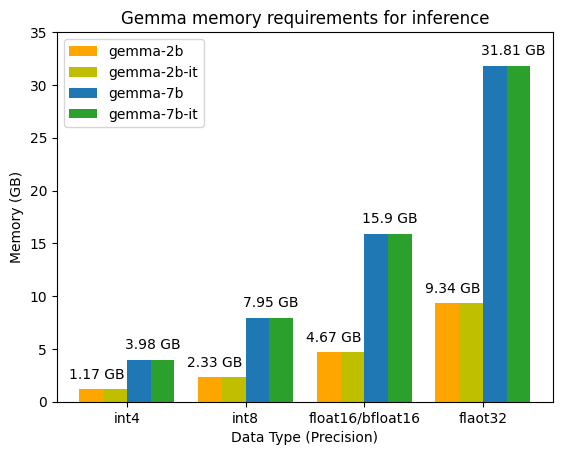

In [18]:
# Utility Code, You can ignore
utils.plot_memory_usage()

As you can see, there are 4 different data types in the charte. Data types are commonly called `dtype` by the Machine Learning community. To understand what these dtypes are, we need to talk about how computers store data.<br>
Modern computers can store, manipulate and display(if displayable) a variety of information like images, musics, videos, texts, gifs, LLM weights... But under the hood all of these information are simply numbers that have some format and folow some protocols that allow the computer to distinguish them and know how process them. We are not going deeper into how information are stored and presented, but if you are curious, you can check these [ASCII](https://en.wikipedia.org/wiki/ASCII) and [Unicode](https://en.wikipedia.org/wiki/Unicode) for text, [Digital image](https://en.wikipedia.org/wiki/Digital_image) or [RGB color model](https://en.wikipedia.org/wiki/RGB_color_model) for images or simply google it (e.g: how songs are represented in computer systems), there are tons of information available about this. However, all you need to understand will be explained in it, only do extra research if you want to dig deep into certain topics. Let's continue! Computers only store numbers, but their are different type of them, for example:
- int4: 4-[bit](https://en.wikipedia.org/wiki/Bit) signed integer, can store numbers from -8 to 7 and require half a [byte](https://en.wikipedia.org/wiki/Byte) of memeory to store one value
- int8: 8-bit signed integer, can store numbers from -128 to 127 and require 1 byte of memory to store one value
- float16: 16-bit floating-point number, can store numbers from -65,504 to 65,504 and require 2 bytes of memory to store one value
- float32: 32-bit floating-point number, can store numbers from -3<sup>38</sup> to 3<sup>38</sup> and require 4 bytes of memory to store one value
- bfloat16: Created by Google Brain, bfloat16 is an 16-bit floating-point number and occupy 4 bytes of memory per value like float16, but can store numbers from ~-3<sup>38</sup> to ~3<sup>38</sup> similar to float32.

I hope that now, it makes sense why gemma-7b requires at least 3.98 GB of memory in int4 and 31.91 GB in float32.
You may be wondering, if we can use the models in int4 and use 4 times less memory, why not only use int4? Because quantization comes with loss in precision. For instance 2.4 in float16 or float32 will be 2 in int8 and int4.

<p class="alert alert-block alert-info"><b>Note:</b> This is a very simplified explanation of quantization. And the main thing you need to remember is: The higher the number of bits a dtype has, the more precise it is and the more it consumes memory. Quantization doesn't only help reduce memory, it can also speed-up inference.</p>

To quantize a model, we can simply use the `transformers` library and tell it to load our model using a 4-bit dtype for instance. Then the `transformers` will use under the hood another library call `bitsandbytes` to perform the quantization. Let's translate this into code:


In [19]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch
# Let's create a function that we can reuse later to load a 4-bit quantized gemma-2b-it model with it's tokenizer
def load_model(model_id=gemma_2b_it, tokenizer_id=gemma_2b_it, load_in_4bit=True, device="auto", quant_compute_dtype=torch.float16, torch_dtype=None):
    # Let's create the quantization configuration
    quantization_config = BitsAndBytesConfig(
        # Tells the library to load the model in a 4-bit data type
        load_in_4bit=load_in_4bit,
        
        # Specify the data type: nf4 is a 4-bit dtype and occupy only Half a byte like int4 that we saw above
        bnb_4bit_quant_type='nf4',
        
        # Although the weight are store in the nf4 type, they need to be one of (bfloat16, float16, or float32) during computation, so let's set the compute type
        bnb_4bit_compute_dtype=quant_compute_dtype,
    ) if load_in_4bit else None
    
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_id)
    
    # Load the model with the quantization configurations
    model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=quantization_config, device_map=device, torch_dtype=torch_dtype)
    
    return tokenizer, model


### 2.e Quiz 1 <a id="2.e"></a>

In [20]:
# Utility Code, You can ignore
utils.display_quiz_1()

### 2.f Key Takeaways <a id="2.f"></a>

- There are 4 different Gemma models as of 2 Apr 2024: gemma-7b-it, gemma-2b-it, gemma-7b, and gemma-2b. The models with the `it` suffix are Instruction Tuned and are chat-friendly, if your usecase require a chat interface an Instruction Tuned model is probably what you need. The gemma-7b-it model require more memory and are more computatioanly expensive that the gemma-2b-it, but is better at understanding and executing complex tasks with less prompt engineering effort.
- Instruction Tunned models are good at executing instructions like ChatGPT and Gemini while pretrained models aren't.
- Quantizatoin helps reduce memory and computation requirements at the cost of some precision. If there is a big float32 model that you want to use but have a small GPU, you can use float16 or bfloat16 to have 50% memory reduction, int8 to have 75% reduction, or int4 to have 87.5% memory reduction and an increase in inference speed and a loss in precision.

# 3. Creating the Coder: Fine-Tuning <a id="3."></a>
We already talked about fine tuning when I explained the diffrence between pretrained and instruction tuned (which is a type of fine-tuning) models. Basicly, fine-tuning is the process of taking a base model that already have some knowledge, teaching the model to laverage it knowledge to perform downstream tasks, if the base model was able to perform the task before fine-tuning it will be better at it otherwise it will be now able to perform it.
We will take the `gemma-2b-it` with all it's knowledge and ability to understand natural language and code, and fine-tune it to be specialized and better at teaching to write code to solve Data Science problems.
  
There are different ways to fine-tune an LLMs:

**Full Fine-Tuning:**

During full fine-tuning, all the parameters of the pre-trained LLM are adjusted during training on task-specific data. This require a lot more memory for the optimizer state, the gradients, the activations, and some temporary storage during fine-tuning. All of this extra memory can be up to 6x higher than the model's weight. For example, to perform full-fine tuning on the `gemma-2b-it` with `bfloat16` or `float16` dtype, we need **~4.67 GB** to load the model for inference. However, we need around **18.67 GB** to perform full fine-tuning using an Adam optimizer. These numbers may vary depending on the implementation but in general, training/fine-tuning require a lot more memory than inference.
    
<br>

**Parameter-Efficient Fine-Tuning (PEFT):**

In Parameter-Efficient Fine-Tuning, only a subset of the pre-trained model's parameters are fine-tuned, focusing on those most relevant to the new task. 
* **PEFT Techniques:** There are several approaches within PEFT, categorized into three main types:
    * **Selective Fine-Tuning:** Freezes specific layers (usually earlier layers) of the pre-trained model and fine-tunes only the later layers.
    * **Reparameterization:** Introduces new, low-rank parameters to adapt the model's behavior for the new task without significantly increasing the overall parameter count. (e.g. Low-Rank Adaptation (LoRA)) 
    * **Additive Methods:** Adds new modules or layers on top of the pre-trained model to handle the specific task. (e.g. Soft Prompts)
    
<br>

#### Here is a table for faster comparaison:

| Feature                 | Full Fine-Tuning | PEFT |
|:-|:-|:-|
| Parameters Updated      | All             | Subset |
| Memory Requirement      | High            | Low |
| Computational Cost      | High            | Low |
| Data Requirement        | High            | Low |
| Risk of Catastrophic Forgetting | High    | Low |
| Potential Performance   | Highest         | Lower but competitive |

<br>
  
## 3.a Parameter-Efficient Fine-Tuning (PEFT) <a id="3.a"></a>

We are going to use **QLoRA (Quantized Low-Rank Adaptation)** to fine-tune our model. But before that, let's briefly talk about **LoRA (Low-Rank Adaptation)**. Instead of fine-tuning the entire model, LoRA is a popular PEFT technique that cleverly introduces a small set of specialized weights. These weights act like controls, allowing you to adjust the model's behavior for specific tasks without modifying the original weights themselves. Checkout this simple [guide](https://huggingface.co/docs/peft/main/en/conceptual_guides/lora) to learn more about LoRA, or read [the paper](https://arxiv.org/abs/2106.09685). Although LoRA is a very powerfull technique, we can't use it to fine-tune quantized models like our 4bit_gemma_2b_it. QLoRA as you have probably guessed, is a method that eliminates this limitation. <br>
    
<br>
    
## 3.b Fine-Tuning Gemma With QLoRA<a id="3.b"></a>
I don't think I can provide a better introduction to QLoRA than the abstract from the [paper QLoRA: Efficient Finetuning of Quantized LLMs](https://arxiv.org/abs/2305.14314) (Don't be intimidated 😁 it's not scary I promise):
> We present QLORA, an efficient finetuning approach that reduces memory usage enough to finetune a 65B parameter model on a single 48GB GPU while
preserving full 16-bit finetuning task performance. QLORA backpropagates gradients through a frozen, 4-bit quantized pretrained language model into Low Rank
Adapters (LoRA). Our best model family, which we name Guanaco, outperforms
all previous openly released models on the Vicuna benchmark, reaching 99.3%
of the performance level of ChatGPT while only requiring 24 hours of finetuning
on a single GPU. QLORA introduces a number of innovations to save memory
without sacrificing performance: (a) 4-bit NormalFloat (NF4), a new data type that
is information theoretically optimal for normally distributed weights (b) Double
Quantization to reduce the average memory footprint by quantizing the quantization
constants, and (c) Paged Optimizers to manage memory spikes. We use QLORA
to finetune more than 1,000 models, providing a detailed analysis of instruction
following and chatbot performance across 8 instruction datasets, multiple model
types (LLaMA, T5), and model scales that would be infeasible to run with regular
finetuning (e.g. 33B and 65B parameter models). Our results show that QLoRA
finetuning on a small high-quality dataset leads to state-of-the-art results, even
when using smaller models than the previous SoTA. We provide a detailed analysis
of chatbot performance based on both human and GPT-4 evaluations showing that
GPT-4 evaluations are a cheap and reasonable alternative to human evaluation. Furthermore, we find that current chatbot benchmarks are not trustworthy to accurately
evaluate the performance levels of chatbots. A lemon-picked analysis demonstrates
where Guanaco fails compared to ChatGPT. We release all of our models and code,
including CUDA kernels for 4-bit training
 
When we created our `load_model` function at the end of the [quantization section](#2.d), we included all the configurations need to for our model to be ready for QLoRA fine-tuning, including the new NormalFloat (NF4) dtype mentioned in the paper's abstract above, but we didn't include double quantization as we don't need that for the gemma-2b-it.
   
Let's  start by loading our quantized model:

In [21]:
coder_tokenizer, coder_model =  load_model()

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Since we've created a model with all the quantization configs, we have already done the **Q** part in **QLoRA**, now let's do the **LoRA** part and leave the rest to the Trainer

In [22]:
from peft import LoraConfig

lora_config = LoraConfig(
    task_type="CAUSAL_LM",
    
    # The update matrices rank: The higher the number, the bigger the matrices, thus the higher the number of trainable paramerter
    r=8,
    
    # Controls how much the LoRA weights impact the overall model's behavior. A higher lora_alpha value increases the influence of the adaptations.
    lora_alpha=8,
    
    # Dropout Regularization: This helps prevent the LoRA weights from overfitting.
    lora_dropout= 0.1,
    
    # The modules/layers of the base model to adapt with LoRA
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    
    # Whether to update the bias parameters or not
    bias="none",
)

For the training dataset, their are a lot of public datasets, I tried a few of them but the output style of the finetuned model using those models is not what I wanted. Those dataset are created for training models that execute programing tasks, most of the training example are very task specific. But we need a dataset which implement a data science concept (Linear Regression, PCA, Feature engineering, classification with neural network...) without focusing on a specific task / specific domain. We also want the model to output an explanatory implmentation with simple prompts to not make it required to be a prompt engineering "God" to get the output we want.

So I decided to create the [DSI-Coder Dataset | Teach Data Science Programming](https://www.kaggle.com/datasets/sitaberete/dsi-coder-dataset-teach-data-science-programming) dataset using Gemini and Github Copilot. I used Gemini to create ~10 examples, then moved to vs-code with Github Copilot enabled and used the "Autocomplete" feature. But I still had to review each generated example to make sure they not only generate code but provide detailed explanation. Here is one sample from the dataset:

**PROMPT:** Teach me in detail how to create a neural network with Python <br>
**OUTPUT:**
<blockquote>
<br>Follow these steps to create a neural network:<br> **1. Bringing in the Essentials:**<br><br>**Importing the libraries:**<br>```python<br>import tensorflow as tf<br>from tensorflow import keras<br>```<br>Think of these as our high-tech toolkits. TensorFlow and Keras provide the building blocks for constructing our neural network masterpiece.<br><br>**2. Blueprint for the Brain:**<br><br>**Defining the model:**<br>```python<br>model = keras.Sequential([<br>  keras.layers.Dense(10, input_shape=(784,)),  # First hidden layer with 10 neurons<br>  keras.layers.Activation('relu'), # Activation function (ReLU)<br>  keras.layers.Dense(10),  # Output layer with 10 neurons<br>  keras.layers.Activation('softmax') # Activation function (softmax for probability distribution)<br>])<br>```<br>Here we meticulously craft the architecture of our neural network. It's like sketching the blueprint for an artificial brain!<br><br>- **Sequential model:** A foundational model type, guiding information through layers sequentially.<br>- **Dense layers:** These fully connected layers serve as the workhorses, processing information and learning patterns.<br>- **Activation functions:** They add a sprinkle of non-linearity, allowing the model to capture complex relationships (ReLU for inner layers, softmax for output).<br><br>**3. Setting the Learning Rules:**<br><br>**Compiling the model:**<br>```python<br>model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])<br>```<br>This establishes the ground rules for our network's education:<br><br> **Optimizer:** The master teacher, adjusting weights to minimize errors (we're employing 'adam', a popular choice).<br>- **Loss function:** A guiding compass, measuring how far off our predictions are (we're using 'categorical_crossentropy' for classification).<br>- **Metrics:** Tools to track progress, focusing on accuracy here.<br><br>**4. Gathering and Prepping the Data:**<br><br>**Loading and preprocessing data:**<br>```python<br>from tensorflow.keras.datasets import mnist<br>(train_images, train_labels), (test_images, test_labels) = mnist.load_data()<br>train_images = train_images.reshape(-1, 28 * 28)  # Flatten images<br>test_images = test_images.reshape(-1, 28 * 28)<br>train_images = train_images.astype('float32') / 255.0  # Normalize pixel values<br>test_images = test_images.astype('float32') / 255.0<br>```<br>We're utilizing the MNIST dataset, a collection of handwritten digits, to train our network.<br><br>- **Image flattening:** Reshaping images into a format suitable for the model.<br>- **Normalization:** Scaling pixel values to a common range, ensuring smoother learning.<br><br>**5. The Learning Journey:**<br><br>**Training the model:**<br>```python<br>model.fit(train_images, train_labels, epochs=5, batch_size=128)<br>```<br>This is where the magic happens! The model delves into the training data, iteratively adjusting its internal parameters to better recognize patterns.<br><br>- **Epochs:** Complete passes through the training data, here we're taking five cycles.<br>- **Batch size:** Portioning the data for efficient learning, we're using 128 images per batch.<br><br>**6. Assessing Performance:**<br><br>**Evaluating the model:**<br>```python<br>test_loss, test_acc = model.evaluate(test_images, test_labels)<br>print('Test accuracy:', test_acc)<br>```<br>Putting our model to the test, ensuring it generalizes well to unseen data.<br><br>**7. Predicting the Future:**<br><br>**Making predictions:**<br>```python<br>predictions = model.predict(test_images)<br>```<br>Now the model is ready for action! It can predict on new images, showcasing its ability to generalize and apply its learned knowledge.<br><br>
</blockquote>

The style is not perfect (Gemini over did it when asked in the prompt to be "professional **but freindly**") but it's still an acceptable example.

<br>
Let's load the dataset:
    

In [23]:
from datasets import load_dataset, concatenate_datasets, Dataset

dataset = load_dataset(
    'json',
    data_files="/kaggle/input/dsi-coder-dataset-teach-data-science-programming/dataset_1.1.json",
    split='train',
)

def _filter(example):
    text = example['messages']
    tokens = coder_tokenizer.apply_chat_template(text)
    
    # We want examples where instruction+output has at most 1024 tokens (1024 is the max sequence lenght we will set for training) so that no example will be truncated during training.
    # We are using 1000 to leave room for additional special tokens
    return len(tokens) <= 1000 

dataset = dataset.filter(_filter)

datasets = dataset.shuffle(seed=1111)

# Keep only "messages"
dataset = dataset.remove_columns(['lang']) 
print(dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/181 [00:00<?, ? examples/s]

Dataset({
    features: ['messages'],
    num_rows: 181
})


We will use the [SFTTrainer (Supervised Fine-tuning Trainer)](https://huggingface.co/docs/trl/en/sft_trainer) to fine-tune our model. We will first prepare the training arguments, then create a function that will format our training example data to follow Gemma's "style":
```
<bos><start_of_turn>user
Some instruction<end_of_turn>
<start_of_turn>model
The output<end_of_turn><eos>
```
And finally create the traner by passing it the training arguments, the formatting function, the dataset, the lora configs and other parameters like max_seq_length. Since I'm fune-tunning this on kaggle, I'v set the number of epochs to 1, which means we will have only 1 passage through our data. Feel free to tweek the hyperparameters.

In [26]:
from transformers import TrainingArguments
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM

training_args = TrainingArguments(
    output_dir='/kaggle/working/dsi-coder',
    hub_model_id = 'dsi-coder',
    overwrite_output_dir=True,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=16,
    optim='paged_adamw_8bit',
    learning_rate=1e-4,
    warmup_ratio=0.08,
    num_train_epochs=1,
    lr_scheduler_type='cosine',
    report_to="none",
    logging_steps=1,
)

coder_tokenizer.padding_side = 'right' # Preferred for training/fine-tuning
coder_tokenizer.padding_token = coder_tokenizer.eos_token

# The SFTTrainer expect the training data to be a text, not X,y pairs. This function format the instruction and output pairs in a single text following the "gemma style".
def formatting_prompts_func(example):
    output_texts = []
    
    for i in range(len(example['messages'])):
        messages = example['messages'][i]
        
        chat = coder_tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
        chat = chat.removeprefix(coder_tokenizer.bos_token)
        
        if i == 5:
            print(chat) # Check format
        
        output_texts.append(chat)
        
    return output_texts

# By default SFTTrainer has the same learning objectif as during pretraining: predicting the next token of the input sequence by applying a mask to it to have an "input" "output" pair.
# In orther to train the model on only generating the output given an input, we need to use the DataCollatorForCompletionOnlyLM and provide a template showing where the output starts.
response_template = "<start_of_turn>model\n"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=coder_tokenizer)

coder_trainer = SFTTrainer(
    coder_model,
    args=training_args,
    train_dataset=dataset,
    max_seq_length=1024,
    peft_config=lora_config,
    tokenizer=coder_tokenizer,
    data_collator=collator,
    packing=False,
    formatting_func=formatting_prompts_func
)


Map:   0%|          | 0/181 [00:00<?, ? examples/s]

<start_of_turn>user
I'm learning about neural networks. Can you guide me on implementing a basic neural network in Python?<end_of_turn>
<start_of_turn>model
Absolutely! Let's dive into building a basic neural network in Python. Here's a step-by-step guide to get you started:

**1. Importing the Essential Libraries:**

```python
import tensorflow as tf
from tensorflow import keras
```

We're bringing in TensorFlow and Keras, the dynamic duo for creating neural networks in Python.

**2. Defining the Neural Network Architecture:**

Here's a simple example of a feedforward neural network with one hidden layer:

```python
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),  # Input layer (flattening the 28x28 image)
    keras.layers.Dense(128, activation='relu'),  # Hidden layer with 128 neurons and ReLU activation
    keras.layers.Dense(10, activation='softmax')  # Output layer with 10 neurons (for 10 classes) and softmax activation
])
```

**3. Compiling the Model:*

Now that we have the trainer, we just need to call the `trian()` method and observe the logs:

In [27]:
coder_trainer.train()

Step,Training Loss
1,1.424800
2,1.386000
3,1.332400
4,1.498000
5,1.342400
6,1.197900
7,1.244300
8,1.259000
9,1.233600
10,1.087000


TrainOutput(global_step=11, training_loss=1.2921179099516436, metrics={'train_runtime': 305.6554, 'train_samples_per_second': 0.592, 'train_steps_per_second': 0.036, 'total_flos': 1022179248353280.0, 'train_loss': 1.2921179099516436, 'epoch': 0.9723756906077348})

Let's plot the training loss.

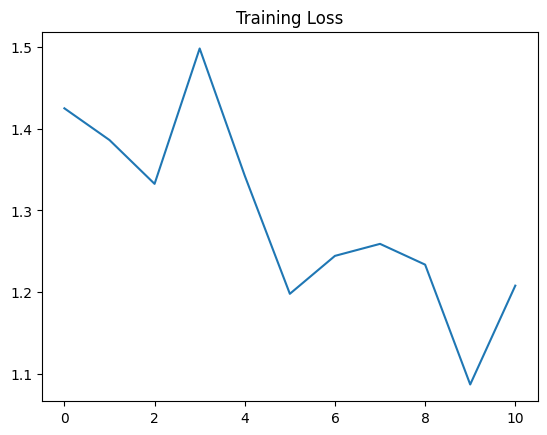

In [28]:
import matplotlib.pyplot as plt

loss = [log['loss'] for log in coder_trainer.state.log_history[:-1]]
plt.title('Training Loss')
plt.plot(loss)

Well, it is not the most stable training but based on the time and compute power we have, this is acceptable. We will test our fine-tuned model and compare it with the original gemma_2b_it later, but for now let's save and publish our model.

Let's start by Saving the LoRA adapter.

In [29]:
import gc

# Free GPU memeory allocated during training
gc.collect()
torch.cuda.empty_cache()

coder_trainer.save_model('dsi-coder-lora') # Save LoRA weights on disk

/opt/conda/lib/python3.10/site-packages/peft/utils/save_and_load.py:173: UserWarning: Could not find a config file in /kaggle/input/gemma/transformers/2b-it/3 - will assume that the vocabulary was not modified.
  warnings.warn(


Now let's merge the lora adapter to the original gemma model to get our final fine-tuned model and save it.

In [30]:
from peft import PeftModel

gemma = AutoModelForCausalLM.from_pretrained(gemma_2b_it, torch_dtype=torch.bfloat16)
lora_adapter_path = 'dsi-coder-lora'
gemma_with_lora = PeftModel.from_pretrained(gemma, lora_adapter_path) # This will load the LoRA weights we saved and "add" them to the gemm model
fine_tuned_model = gemma_with_lora.merge_and_unload() # Merge the LoRA adapter to the gemma model
fine_tuned_model.save_pretrained('dsi-coder-full-model')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

#### Publishing the fine-tuned model

Publishing is optional, but this makes it easy to reuse the model without fine-tuning it each time we want to use it.

Publish the model to kaggle hub. If you haven't changed the code above, the model should be in the `/kaggle/working/dsi-coder-full-model` folder. For this you will need a [kaggle key and username](https://www.kaggle.com/docs/api?utm_me=#authentication), then directly add them to the code below or to [kaggle secrets](https://www.kaggle.com/discussions/product-feedback/114053)

In [34]:
# import kagglehub
# from kaggle_secrets import UserSecretsClient

# user_secrets = UserSecretsClient()
# os.environ['KAGGLE_KEY'] = user_secrets.get_secret("KaggleSecret")
# os.environ['KAGGLE_USERNAME'] = user_secrets.get_secret("KaggleName")

# This is commented to prevent publishing when saving new versions of this notebook 
# Uncomment to publish the model

kagglehub.model_upload('sitaberete/dsi-coder/transformers/2b', '/kaggle/working/dsi-coder-full-model', 'Gemma')

Starting upload for file model-00002-of-00002.safetensors
Uploading: 100%|██████████| 67.1M/67.1M [00:01<00:00, 56.1MB/s]
Upload successful: model-00002-of-00002.safetensors (64MB)
Starting upload for file model.safetensors.index.json
Uploading: 100%|██████████| 13.5k/13.5k [00:00<00:00, 35.7kB/s]
Upload successful: model.safetensors.index.json (13KB)
Starting upload for file config.json
Uploading: 100%|██████████| 719/719 [00:00<00:00, 1.74kB/s]
Upload successful: config.json (719B)
Starting upload for file model-00001-of-00002.safetensors
Uploading: 100%|██████████| 4.95G/4.95G [00:39<00:00, 126MB/s] 
Upload successful: model-00001-of-00002.safetensors (5GB)
Starting upload for file generation_config.json
Uploading: 100%|██████████| 137/137 [00:00<00:00, 401B/s]
Upload successful: generation_config.json (137B)


BackendError: Permission 'models.update' was denied

Publish the model to hugging face. If you did't set your hugging face token earlier, set it before running the cell below. The type of the token need to be `write` to publish to the hub.

In [ ]:
# This is commented to prevent publishing when saving new versions of this notebook 
# Uncomment to publish the model

#fine_tuned_model.push_to_hub('dsi-coder')

#### Testing the fine-tuned model dsi-coder

In [32]:
prompts = [
    "Teach me how to build a neural network classifier for plant diseases detection",
    "Give me an example of how to do hierarchical clustering.",
    "Explain to me how to create a house prices predictor with sklearn. Provide as much details as you can.",
    "How to implement a random forest classifier in Python using scikit-learn. Keep it short",
    "How to handle missing data in R using the tidymodels package",
    "Teach me in detail how to create a neural network with tensorflow and keras",
    "I want to learn about image segmentation using deep learning with pytorch",
    "I want to learn NLP, Can you guide me on implementing a text classification model with the transformer library?"
]

def batch_inference(tokenizer, model, prompts):
    input_ids = tokenizer(prompts, return_tensors='pt', padding='longest').to('cuda')
    outputs = model.generate(**input_ids, max_new_tokens=1024)
    outputs_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return outputs_text

ft_coder_tokenizer, ft_coder_model =  load_model('/kaggle/working/dsi-coder-full-model')

dsi_coder_outputs = batch_inference(
    ft_coder_tokenizer,
    ft_coder_model,
    prompts,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [37]:
# Utility Code, You can ignore
outputs = [
    ('DSI Coder Outputs', dsi_coder_outputs),
]
utils.display_formatted_models_comparaison_outputs(outputs)

DSI Coder Outputs  

 
 
 Teach me how to build a neural network classifier for plant diseases detection using Python. 
 **Step 1: Import necessary libraries** ```python import pandas as pd import numpy as np import matplotlib.pyplot as plt from sklearn.preprocessing import StandardScaler from sklearn.linear_model import LogisticRegression from sklearn.metrics import accuracy_score ``` **Step 2: Load and prepare the dataset** ```python # Load the dataset data = pd.read_csv('plant_disease_dataset.csv') # Select the relevant features and target variable features = ['spectral_features'] target = 'disease' # Split the dataset into training and testing sets X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42) ``` **Step 3: Feature scaling** Scale the features to a similar range for better performance. ```python scaler = StandardScaler() X_train_scaled = scaler.fit_transform(X_train) X_test_scaled = scaler.transform(X_test) ``` **Step 4: Train the neural network classifier** ```python # Create a neural network classifier classifier = LogisticRegression() # Train the classifier classifier.fit(X_train_scaled, y_train) ``` **Step 5: Evaluate the classifier** ```python # Evaluate the classifier on the test set accuracy = accuracy_score(classifier.predict(X_test_scaled), y_test) print('Accuracy:', accuracy) # Plot the accuracy over time plt.plot(range(1, len(y_test) + 1), accuracy, label='Accuracy') plt.xlabel('Number of training samples') plt.ylabel('Accuracy') plt.title('Accuracy of the Neural Network Classifier') plt.legend() plt.show() ``` **Step 6: Save the trained model** Save the trained model for future use. ```python classifier.save('plant_disease_classifier.h5') ``` **Additional notes:** * Use cross-validation to ensure the model is not overfitting. * Experiment with different hyperparameters of the neural network classifier. * Consider using ensemble methods for better accuracy. 
 
 

 
 Give me an example of how to do hierarchical clustering. 
 **Step 1: Load and prepare the data** ```python import pandas as pd # Load the data data = pd.read_csv('data.csv') # Perform data cleaning and feature scaling data['feature_1'] = data['feature_1'].astype(float) data['feature_2'] = data['feature_2'].astype(float) ``` **Step 2: Choose a clustering algorithm** There are many hierarchical clustering algorithms available, but the most common are: * **Agglomerative clustering:** This algorithm starts with individual data points and then merges them together until a single cluster is formed. * **Hierarchical clustering:** This algorithm starts with a single cluster and then splits it into two or more clusters. This process is repeated until each cluster contains only a single data point. **Step 3: Perform hierarchical clustering** ```python # Agglomerative clustering from sklearn.cluster import AgglomerativeClustering # Hierarchical clustering from sklearn.cluster import HierarchicalClustering # Perform hierarchical clustering model = AgglomerativeClustering(n_clusters=3) model.fit(data) # Print the results print(model.labels_) ``` **Step 4: Evaluate the results** Once the hierarchical clustering has been performed, it is important to evaluate the results to ensure that the clusters are meaningful and representative. This can be done by: * **Analyzing the cluster structure:** The cluster structure can be visualized using a dendrogram or other plot. * **Calculating metrics such as silhouette score or Calinski-Harabasz index:** These metrics can be used to compare the quality of different clustering algorithms. * **Inspecting the data within each cluster:** This can be done by printing the data points in each cluster or by creating heatmaps of the features. **Step 5: Use the results for decision-making** Once the hierarchical clustering has been performed, it can be used for decision-making. For example, the clusters can be used to identify groups of customers with similar characteristics or to i

As you can see our coder is doing a great job. However we did only one epoch on a few exemples(training data), so our fine-tuned model isn't very different from the original gemma-2b-it. The reason why I chose not "heavily" fine-tune it is because with a good prompt, the gemma-2b-it can give pretty good results without even fine-tuning. But for your usecases (e.g: domain specific tasks, tasks that need to output in some special format...) Gemma may not be good at it Out of the Box. But if you follow the steps above and adapt (when needed) them to your tasks, you will be able to get gemme to do what you want.

We will now free everything allocated during training:

<p class="alert alert-block alert-danger"><b>Important:</b> Before you restart the notebook if you need to free memory or for any other reason, ensure that the model was succesfully uploaded to kaggle/huggingface or download it from here <code>/kaggle/working/dsi-coder-full-model</code></p>

Make sure that your GPU memory have been freed by checking the session metrics, if not restart the notebook because we need memory to load 2 models simultanously later.

In [35]:
del lora_config
del dataset
del coder_model
del coder_tokenizer
del coder_trainer
del fine_tuned_model

gc.collect()
torch.cuda.empty_cache()

## 3.c Quiz 2 <a id="3.c"></a>

In [36]:
# Utility Code, You can ignore
utils.display_quiz_2()

## 3.d Key Takeaways <a id="3.d"></a>

1. **Full Fine-Tuning:** This method adjusts all the parameters of the pre-trained LLM during training on task-specific data. It requires a lot of memory and computational resources but can achieve the highest potential performance.

2. **Parameter-Efficient Fine-Tuning (PEFT):** This approach focuses on training only a subset of the model's parameters, specifically those most relevant to the new task. PEFT techniques like LoRA (Low-Rank Adaptation) can significantly reduce memory usage and training time while maintaining good performance.

3. Fine-tuning is not always necessary, it's a best practice to first try out the base model on the target task with prompt engineering.
    
4. The quality of the resulting model after training or fine-tuning highly depends on the quality of the training data. Sometimes, public datasets aren't suited/enough for our spcific usecase in which case creating our own may be the best thing to do.


# 4. Building the Librarian: Retrieval-Augmented Generation (RAG) <a id="4."></a>

Large language models (LLMs) have revolutionized various fields with their ability to process and generate human-quality text. However, LLMs often struggle with tasks requiring factual accuracy and access to up-to-date information. Retrieval-Augmented Generation (RAG) addresses this limitation by incorporating an information retrieval component into the LLM architecture. This chapter delves into RAG, exploring its inner workings and the crucial role of indexing in the retrieval process.

RAG enhances the capabilities of LLMs by leveraging external knowledge sources. It achieves this through a two-stage process:

1. **Retrieval:** Given a user prompt or query, RAG employs a retrieval system to identify relevant documents or passages from a knowledge base. This knowledge base can be a curated dataset, domain-specific corpus, or even publicly available resources like Wikipedia.
2. **Augmented Generation:** The retrieved documents are then fed alongside the original prompt to the LLM. This augmented context allows the LLM to ground its response in factual information, improving the accuracy and reliability of the generated text.


#### Benefits of RAG

RAG offers several advantages over traditional LLM approaches:

* **Improved Factual Accuracy:** By grounding the LLM in external knowledge sources, RAG mitigates the risk of factual errors and hallucinations that can occur with LLMs trained on massive but potentially inconsistent datasets.
* **Enhanced Domain Specificity:** RAG allows for the integration of domain-specific knowledge bases, enabling LLMs to excel in tasks requiring specialized expertise.
* **Flexibility and Adaptability:**  New information can be readily incorporated into the knowledge base, allowing the RAG system to stay up-to-date and adapt to evolving knowledge domains. 
* **Transparency and Trust:** By providing access to the retrieved documents used for generation, RAG fosters greater transparency and builds trust in the LLM's reasoning process.


## 4.a The Retriever <a id="4.a"></a>

The success of RAG hinges on the efficiency and effectiveness of the information retrieval component. This is where indexing plays a critical role. Indexing involves creating a comprehensive data structure that facilitates the rapid retrieval of relevant documents based on user queries. Common indexing techniques include:

* **Keyword Indexing:** Words and phrases are extracted from documents and stored along with document identifiers. Queries involving these keywords can then be efficiently matched against the index to locate relevant documents.
* **Entity Indexing:**  This approach focuses on identifying and indexing named entities like people, places, and organizations within the knowledge base. This allows for retrieving documents based on specific entities mentioned in the user prompt.
* **TF-IDF (Term Frequency-Inverse Document Frequency):** TF-IDF is a widely used technique in information retrieval and natural language processing (NLP) that goes beyond simple keyword matching. It analyzes a document's content to determine how important each word is to the overall topic, considering both how often the word appears within the document itself (term frequency) and how often it appears across a collection of documents (inverse document frequency). 
* **Semantic Indexing:** Techniques like TF-IDF (Term Frequency-Inverse Document Frequency) are a stepping stone towards leveraging semantic similarity. However, they only analyze word frequency within documents. Semantic indexing incorporates **embedding vectors** to represent the contextual meaning of words. These embeddings capture the relationships between words, allowing retrieval based on semantic similarity to the user query. 
    
Effective indexing ensures that the retrieval process is fast and retrieves the most relevant documents for the LLM to leverage during generation. The choice of indexing technique depends on the nature of the knowledge base and the types of queries that will be used to retreive documents. We will use the **Semantic Indexing** technique, but we will not implement it ourselves. We will instead use [LangChain](https://github.com/langchain-ai/langchain), [Chroma](https://github.com/chroma-core/chroma), [BAAI/bge-small-en](https://huggingface.co/BAAI/bge-small-en) without know the implementation details.

#### Data Source
We need a data source that contains information about Data Science. The "Python Data Science Handbook" is a good ressource that teaches most of the fondamental concepts of Data Science with some code example in python. The author of the book created a [open-source repository](https://github.com/jakevdp/PythonDataScienceHandbook) containing the entire book in the form of Jupyter Notebooks.
I converted the notebooks into markdown files and created a [dataset](https://www.kaggle.com/datasets/sitaberete/python-datascience-handbook-dataset-md) from them using this notebook. We are going to use those markdown files as our data source.
Before we start interacting with LangChain, if you have a LangChain account add your API key bellow to use [LangSmith](https://smith.langchain.com) for tracing purpose. But this is totaly optional, it allows you to "monitor" you apps built with LangChain on a dashboard.

In [39]:
## from kaggle_secrets import UserSecretsClient
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = UserSecretsClient().get_secret("LangchainSecret") 

We also need some dependencies:

In [40]:
!pip install -U langchain langchain-community chromadb sentence_transformers wikipedia

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 1.1 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 1.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opentelemetry-sdk to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 6.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.5/525.5 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 52.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.9/698.9 kB 20.9 MB/s eta 0:00:00

Now let's load our data using LangChain.

In [41]:
from langchain_community.document_loaders import DirectoryLoader, TextLoader

loader = DirectoryLoader(
    '/kaggle/input/python-datascience-handbook-dataset-md',
    loader_cls=TextLoader,
    glob='*.md',
    show_progress=True,
    # Exclude irrelevant documents
    exclude=[
        '05.15-Learning-More.md',
        '06.00-Figure-Code.md'
    ],
)
docs = loader.load()

print(f"{len(docs)} Documents loaded")

100%|██████████| 63/63 [00:00<00:00, 134.80it/s]

63 Documents loaded


#### Creating the retreiver

Before we create the retreiver, we need to split our documents into chunks because we don't want to retreive a whole markdown file for a single query.
There's a trade-off when splitting documents for retrieval:
- Smaller documents: Better capture meaning, but lose context
- Larger documents: Preserve context, but lose embedding accuracy

The `ParentDocumentRetriever` from LangChain addresses this by storing small chunks with parent document IDs for retrieval. This allow us to have accurate search with small chunks yet preserve context by reteiving larger (parent) chunks.

In [42]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.storage import InMemoryStore
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain.retrievers import ParentDocumentRetriever

parent_splitter = RecursiveCharacterTextSplitter(chunk_size= 1000, chunk_overlap=200)
child_splitter  = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=100)

embedding_model = HuggingFaceBgeEmbeddings(model_name='BAAI/bge-small-en')

# The vectorstore to use to index the child chunks
child_docs_store = Chroma(
    # We tell chroma to split the parents according to the `parent_splitter` provided instead of returning the entire document
    collection_name="split_parents",
    embedding_function=embedding_model
)
# The storage layer for the parent documents
parent_docs_store = InMemoryStore()

retriever = ParentDocumentRetriever(
    vectorstore=child_docs_store,
    docstore=parent_docs_store,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter,
    search_kwargs={"k": 1},
)

retriever.add_documents(docs)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/90.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/129 [00:00<?, ?it/s]

# 5. The Agent: Put it all together <a id="5."></a>

At last, let's dive into the world of **AI agents**! Just imagine a software program that can not only think and learn but also act accordingly in the real world. That's the realm of AI agents, and they're becoming increasingly sophisticated and popular. AI agent is the hottest topic of the moment in AI, new agent based product, tools an services are born almost every day. The last Google Cloud next keynotes had one majore topic, AI agents. 

Now, there are different levels of reasoning when it comes to AI agents.  On one end, you have simple agents that react based on pre-programmed rules.  For instance, a thermostat is a basic AI agent that reacts to the temperature and turns the heating or cooling system on or off.

On the other hand, you have complex AI agents that can reason and plan before taking action.  These agents can consider different options, weigh the potential consequences, and then choose the course of action that's most likely to achieve their goal.  Self-driving cars are a good example of complex AI agents.  They use a variety of sensors to perceive their surroundings, reason about the traffic situation, and then decide how to navigate the road safely.

So, what kind of reasoning abilities do AI agents need?  Well, it depends on the task at hand.  For some tasks, like playing a simple game, a relatively simple level of reasoning might suffice.  But for more complex tasks, like driving a car or managing a business, AI agents need to be able to reason at a much higher level.

Let's take a look at a specific type of AI agent called a **ReAct (Reasoning and Acting)** agent.  This is a recent development described in this [research paper](https://arxiv.org/abs/2210.03629). ReAct agents are designed to combine reasoning and acting capabilities. They can not only think about a problem but also take actions in the real world to gather more information or solve the problem. This is a powerful approach because it allows the agent to be more flexible and adaptable.

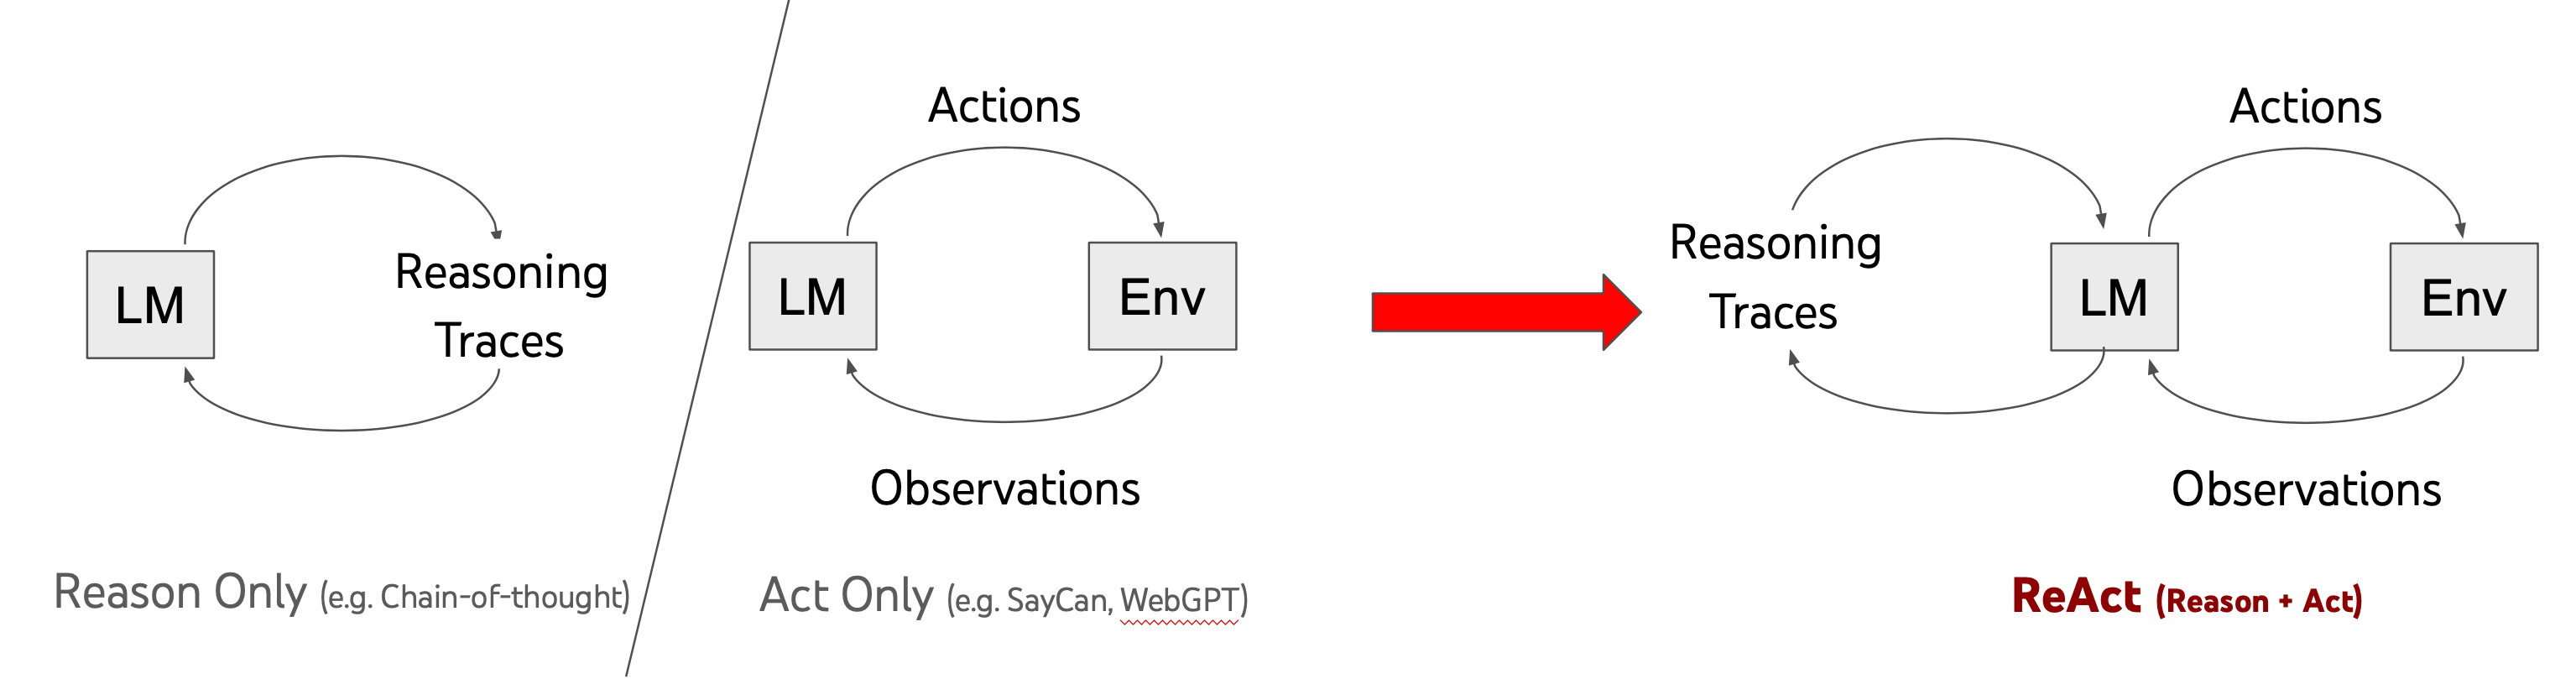

ReAct agents are particularly well-suited for tasks that require both reasoning and acting, such as question answering, fact verification, and interactive decision-making.  Imagine a conversational AI system that can not only answer your questions but also use tools (Search engines, APIs, custom functions...) to perform some tasks or for additional information to provide you with the most comprehensive answer possible. That's the kind of power that ReAct agents hold.

There are different architectures for ReAct agents, but some popular ones include using LLMs for the reasoning component and tools for the acting component. We going to use this architecture with the help of [LangChain](https://python.langchain.com/docs/get_started/introduction)

ReAct Agent are in the category of agent that require high level reasoning engines (LLMs in our case). The chartes below shows how different sizes (number of parameters) of LLMs perform in different type agents:

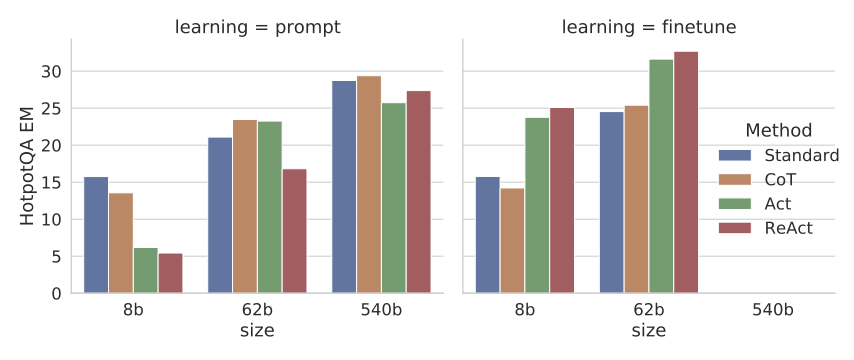




As you can see when not fine-tuned, small LLMs (8 Bilion parameters) perform poorly. We are not fine-tuning Gemma for this purpose in this tutorial, we are going to try it with a prompt and see how it performs. However we are going to use the 7 bilion which has higher reasoning capability than the 2 billion.

## 5.a Gemma as A ReAct Agent <a id="5.a"></a>

This is what we are goint to build at first:
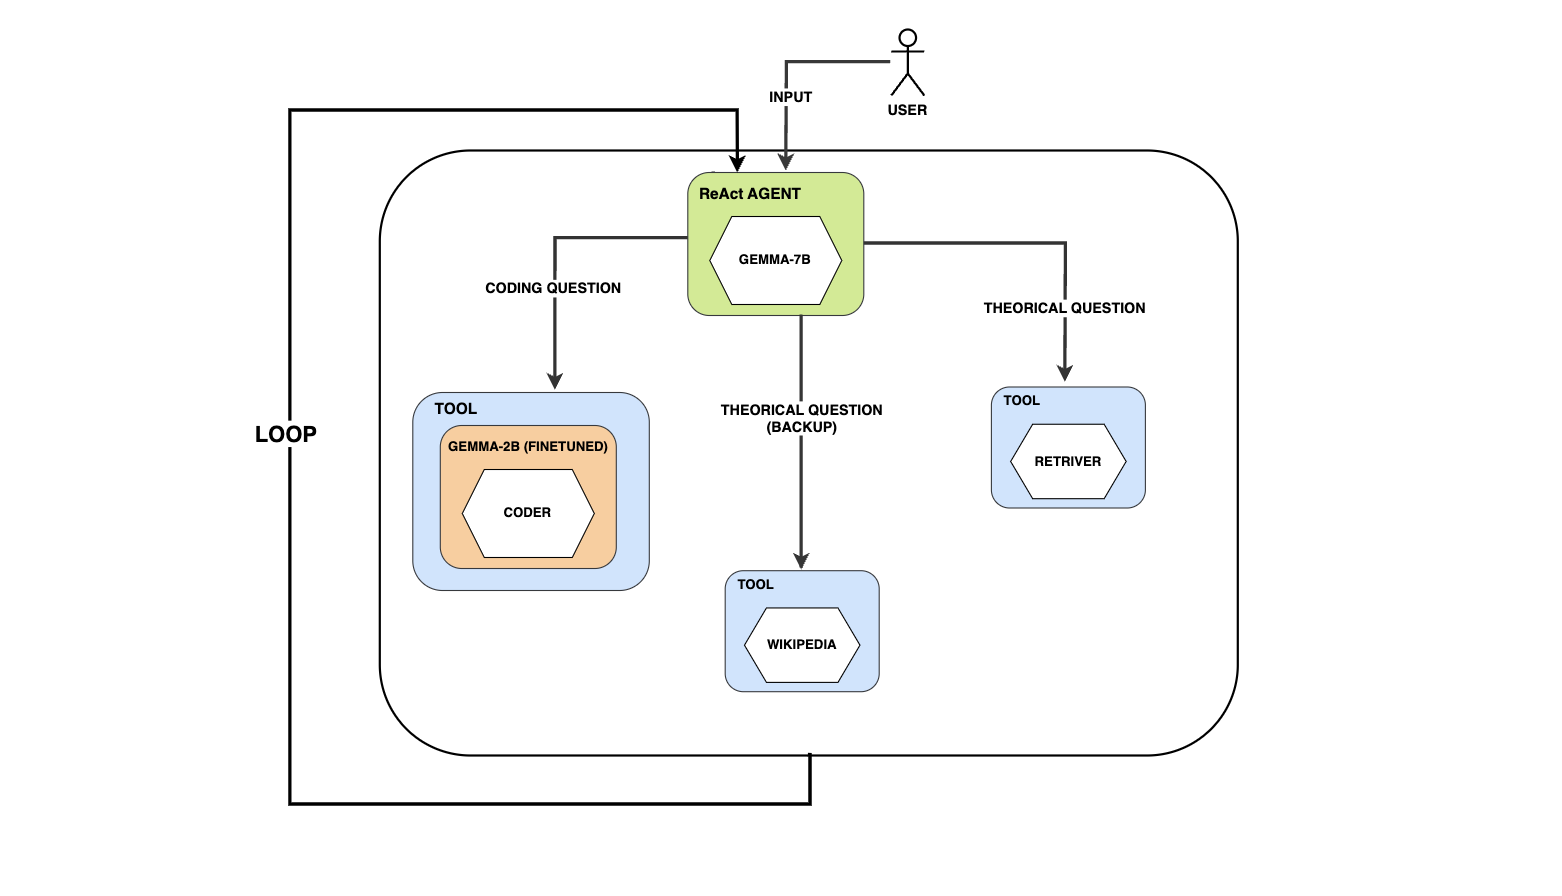

We will build an ReAct agent that will use `gemma-7b-it` as a reasoning engine and will have access to 3 tools:
- The coder (our fine-tuned model) to answer code implementation related question
- The retreiver (Not the entire RAG yet) to anser theoretical/general Data Science Question
- Wikipedia as a backup to our retreiver, wikipedia contain up to date information while the retreiver contain only what we feed in during indexing.

When the agent receive an input, It goes through a thought process to decide what tool is best suited, then use the tool and get an output/response from the tool and then goes throug a thought process again to check if it has enough information to answer the question. If yes, answer otherwer restart the though process and pick another tool or use the same with the different input. This can repeat until the agent decide that it has enough data to give an answer or until a stop condition is met (the stop condition can be a maximum number of iteration). This repeating process is represanted by the loop in the diagram above.
For example, if a user ask a Data Science question, the agent can use the retriver or wikipedia to get some information and then use the coder to get an implementation example and then combined that and answer to the question.


LangChain's LLMs have a specific interface. We will start by creating `GemmaLangChain` to make Gemma compatible with LangChain ecosystem.

In [43]:
from transformers import StoppingCriteria, StoppingCriteriaList
from langchain_core.language_models.llms import LLM


# Allows our LLM to stop generating text as soon as it generate one of the given stop words
class CustomStoppingCriteria(StoppingCriteria):
    def __init__(self, stops:tuple, tokenizer):
        self.stops = stops
        self.tokenizer = tokenizer
    
    def __call__(self, input_ids: torch.LongTensor, score: torch.FloatTensor, **kwargs) -> bool:
        input = self.tokenizer.decode(input_ids[0])
        return input.endswith(tuple(self.stops))

    
class GemmaLangChain(LLM):
    model: object
    tokenizer: object

    @property
    def _llm_type(self) -> str:
        return str(type(self.model))

    def _call(self, prompt, stop, run_manager= None, **kwargs) -> str:
        stopping_criteria = StoppingCriteriaList([
            CustomStoppingCriteria(stop, self.tokenizer)
        ]) if stop else None
        
        input_ids = self.tokenizer(prompt, return_tensors='pt').to('cuda')
        output = self.model.generate(**input_ids, max_new_tokens=1024, stopping_criteria=stopping_criteria)
        output_text = self.tokenizer.decode(*output)[len(prompt) - 5:]
        
        return output_text

Let's load our LLMs (the coder, and gemma_7b):

In [44]:
gemma_7b_tokenizer, gemma_7b_model = load_model(gemma_7b_it, gemma_7b_it)
gemma_langchain = GemmaLangChain(model=gemma_7b_model, tokenizer=gemma_7b_tokenizer)

coder_tokenizer, coder_model = load_model('/kaggle/input/dsi-coder/transformers/2b/2') # Our fine-tuned model

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Then create and describe our tools. The tool descriptions allow the LLM (the agent's reasoning engine) to know what tool is best suited for a given question in a particular state.

In [45]:
from langchain.tools.retriever import create_retriever_tool
from langchain_core.tools import tool
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

stop_word = '\nAction Output:'

data_science_book = create_retriever_tool(
    retriever,
    'python_data_science_handbook',
    'This tool teaches the fundamental data science concepts. Use this tool to for theoretical questions. Don\'t rely on this tool for code implementation tasks. The input is a keyword(s).',
    document_separator="\n\n"
)

wikipedia = WikipediaQueryRun(
    name="wikipedia",
    description="'A wrapper around wikipedia which can provide up-to-date information Data Science. The input must be a keyword(s)",
    api_wrapper=WikipediaAPIWrapper(
        top_k_results=1, 
        doc_content_chars_max=1000
    ),
)

@tool
def programming_tool(question: str) -> str:
    """An LLM that writes codes that can perform a variety of Data Science Tasks. It implements computer code in Python, R, Tensorflow, Pytorch, Keras... Use this tool for programming/coding questions. The input must be a prompt."""
   
    question = question.removesuffix(stop_word) # The agent was including the stop word
    
    prompt = f"""
    You are a helpful assistant, the Coder from the DSI Crew (Data Science Instructor Crew). Your role is to write/implement computer code for a given Data Science task or question.

    Make sure to produce a clear, detailed, explanatory and relevant code. Don't just write the code, explain it in details and be professional with a teacher tone in your explanation.
    
    Answer to the following question as best as you can according to the instructions above.
    Question: {question}

    Answer:
    """
    
    input_ids = coder_tokenizer(prompt, return_tensors='pt').to('cuda')
    output = coder_model.generate(**input_ids, max_new_tokens=1024)
    return coder_tokenizer.decode(*output, skip_special_tokens=True)[len(prompt):]

# The function signature in the tool description was missguiding the agent.
programming_tool.description = programming_tool.description.removeprefix('programming_tool(prompt: str) -> str - ')

tools = [wikipedia, programming_tool, data_science_book]

And finaly create our agent:

In [46]:
from langchain.agents import AgentExecutor, create_react_agent
from langchain_core.prompts import PromptTemplate

agent_prompt = PromptTemplate.from_template("""Your role is to answer to Data Science questions asked by a student.

You have access to the following tools to help you answer to the question:

{tools}

If you are asked questions about yourself or your crew, answer directly. Otherwise use the following format:

Question: the input question you must answer
Thought: Always think about the next step. It could be the thinking about the next tool to use or how to formulate the answer
Action: the name of the tool to use, it has to be exctly one of [{tool_names}]. Only the name!
Action Input: the input to the choosen tool
Action Output: the output from the tool
...(this Thought/Action/Action Input/Action Output can repeat N times)
Thought: you now know the answer.
Final Answer: your own detailed answer to the question.

If a tool output something irrelevant to the question, ignore it and use another tool or change your input.
Try to combine multiple tools to give the best answer. For instance, if the question is about Data cleaning, use wikipedia or python_data_science_handbook to know what data cleaning is, then use the programming_tool to know how to implement it in code.
Never use the same tool with the same input twice! 
Don't ask the user to use the any tool! You are the only one who can use the tools.


Begin!

Answer the following questions as best as you can. Make sure to give a clear, detailed and relevant answer, and be professional with a teacher tone. 

Question: {input}

Thought:{agent_scratchpad}
""")

agent = create_react_agent(gemma_langchain, tools, agent_prompt, stop_sequence=[stop_word])

agent_executor = AgentExecutor(
    agent=agent, 
    tools=tools, 
    max_iterations=5,
    verbose=True,
)

In [47]:
result = agent_executor.invoke({"input":  "What is Feature Engineering?"})



> Entering new AgentExecutor chain...

Thought:
Action: python_data_science_handbook
Action Input: Feature Engineering
Action Output:

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

# Feature Engineering

The previous chapters outlined the fundamental ideas of machine learning, but all of the examples assumed that you have numerical data in a tidy, `[n_samples, n_features]` format.
In the real world, data rarely comes in such a form.
With this in mind, one of the more important steps in using machine learning in practice is *feature engineering*: that is, taking whatever information you have about your problem and turning it into numbers that you can use to build your feature matrix.

In this chapter, we will cover a few common examples of feature engineering tasks: we'll look at features for representing categorical data, text, and images.
Additionally, we will discuss derived features for increasing model complexity and imputation of missing data.
This process is commonly referred to as vectorization, as it involves converting arbitrary data into well-behaved vectors.

## Categorical FeaturesThought: 
Action: python_data_science_handbook
Action Input: Categorica

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

```python
vec.get_feature_names_out()
```




    array(['neighborhood=Fremont', 'neighborhood=Queen Anne',
           'neighborhood=Wallingford', 'price', 'rooms'], dtype=object)



There is one clear disadvantage of this approach: if your category has many possible values, this can *greatly* increase the size of your dataset.
However, because the encoded data contains mostly zeros, a sparse output can be a very efficient solution:


```python
vec = DictVectorizer(sparse=True, dtype=int)
vec.fit_transform(data)
```




    <4x5 sparse matrix of type '<class 'numpy.int64'>'
    	with 12 stored elements in Compressed Sparse Row format>



Nearly all of the Scikit-Learn estimators accept such sparse inputs when fitting and evaluating models. `sklearn.preprocessing.OneHotEncoder` and `sklearn.feature_extraction.FeatureHasher` are two additional tools that Scikit-Learn includes to support this type of encoding.

## Text FeaturesThought: 
Action: python_data_science_handbook
Action Input: T

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

## Text Features

Another common need in feature engineering is to convert text to a set of representative numerical values.
For example, most automatic mining of social media data relies on some form of encoding the text as numbers.
One of the simplest methods of encoding this type of data is by *word counts*: you take each snippet of text, count the occurrences of each word within it, and put the results in a table.

For example, consider the following set of three phrases:


```python
sample = ['problem of evil',
          'evil queen',
          'horizon problem']
```

For a vectorization of this data based on word count, we could construct individual columns representing the words "problem," "of," "evil," and so on.
While doing this by hand would be possible for this simple example, the tedium can be avoided by using Scikit-Learn's `CountVectorizer`:


```python
from sklearn.feature_extraction.text import CountVectorizerThought: 
Action: programming_tool
Action Input: CountVectori

Awsome right? The Agent was able to choose to use the `python_data_science_handbook` tool and pass "Feature Engineering" as input. And since the output of the tool ends with an example of "Categorical Features", the Agent used the `python_data_science_handbook` tool again but this time with "Categorical Features" as input (Like if the agent wanted the tool to continue from where it stopped). Then  the Agent chose to use the `programming_tool` with the input "Create dummy variables for categorical features" and then gave a summary in the final answer.

One more time? Let's do it:

In [48]:
result = agent_executor.invoke({"input": "How to implement a house price predictor?"})



> Entering new AgentExecutor chain...

Thought:
I will use the python_data_science_handbook to understand the basic concepts of house price predictors. Then, I will use the programming_tool to write code that can implement a simple house price predictor.

Action: python_data_science_handbook
Action Input: House price prediction concepts
Action Output:

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Finally, we have the logic for predicting labels on new data:
```python
    def predict_proba(self, X):
        logprobs = np.vstack([model.score_samples(X)
                              for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(axis=1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]
```
Because this is a probabilistic classifier, we first implement `predict_proba`, which returns an array of class probabilities of shape `[n_samples, n_classes]`.
Entry `[i, j]` of this array is the posterior probability that sample `i` is a member of class `j`, computed by multiplying the likelihood by the class prior and normalizing.

The `predict` method uses these probabilities and simply returns the class with the largest probability.

### Using Our Custom EstimatorThought: 
I will use the programming_tool to write code that can implement a simple house price

One last time:

In [49]:
result = agent_executor.invoke({"input": "Implement PCA with sklearn"})



> Entering new AgentExecutor chain...

Thought:
I need to know the steps involved in implementing PCA with sklearn.

Action: programming_tool
Action Input: Implement PCA with sklearn
Action Output:```python
    import numpy as np
    import pandas as pd
    from sklearn.decomposition import PCA

    # Load the dataset
    data = pd.read_csv('data.csv')

    # Create a PCA object
    pca = PCA(n_components=2)

    # Fit the PCA model to the data
    pca.fit(data)

    # Transform the data into the principal component space
    transformed_data = pca.transform(data)

    # Print the transformed data
    print(transformed_data)
```

**Explanation:**

1. **Import Libraries**: We first import the necessary libraries, `numpy` for numerical computations, `pandas` for data manipulation, and `sklearn.decomposition` for PCA implementation.


2. **Load Dataset**: We load the dataset into a pandas DataFrame called `data` using the `read_csv` function.


3. **Create PCA Object**: We create a PCA 

Our Agent is able to know what tool is more appropriate depending on the input, however, it is not providing complete answers. It is assuming that the user will check the output of the tools, but we want the Agent to give a full answer based on the output of the tools. I tried modifying the prompt with no success. And if you try different inputs and the tool used output something irrelevant to the question, the agent won't be able to detect that the answer is irrelevant and ignore it in the final answer for most cases, it will instead give an irrelevant answer. But overall, I think this is a pretty good result of a 4-bit quantize 7 Billion parameter model.

LLMs used in ReAct agent are required to have a descent reasonning capability, that's why only "geant" models like GPT-4, Gemini, and models alike are used for ReAct agent in production. You can try using one of those models by checking the [LangChain documentation](https://python.langchain.com/docs/use_cases/question_answering/quickstart). LangChain have many models available including the ones I mentioned. You will just have to provide the API key and instantiate the client then replace the llm above with the client.

## 5.b Gemma as A Routing Agent <a id="5.b"></a>
We are not going to use one of those "geant" models, because our goal is to build AI agents with Gemma. What we are going to do instead to be more confident about out Agent is to simplify it's task a bit. Let's try to use Gemma as a routing Agent. Since it is able to pick a good tool given a question, we can use it to route the answer to the programming_tool or a RAG system (not only a retreiver this time) then the tool will directly answer to the user instead of returning the answer to the agent:

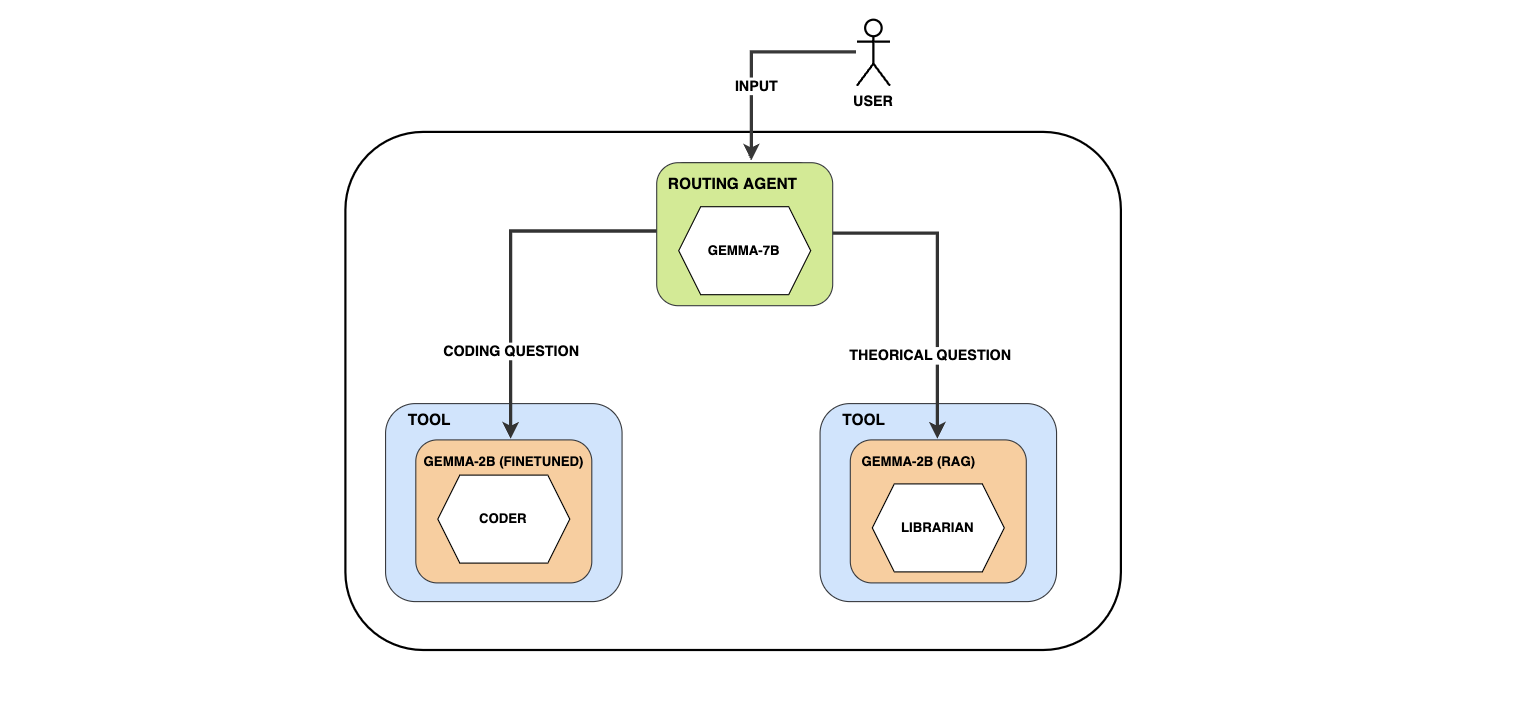

### 5.b1 Completing our RAG: The Generator <a id="5.b1"></a>
Let's start by completing the RAG pipeline we started building first

In [50]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


rag_prompt = PromptTemplate.from_template("""You are a helpful assistant, the Librarian from the DSI Crew (Data Science Instructor Crew). Your role is to answer to Data Science questions asked by a student.

Make sure to give clear, detailed and relevant answers, and be professional with a teacher tone. 

If the following pieces of context are relenvant to the question, use them to responde to the question. 

Context: {context} 

If the Context is not relevant to the question, ingore the Context and provide your own relevant, detailed, explanatory and high quality response. You must answer the question!

Question: {question}

Answer:
""")

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# More about this syntax below
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | rag_prompt
    | gemma_langchain
    | StrOutputParser()
)

<p class="alert alert-block alert-danger">
 <b>Attention:</b> You may have noticed in the prompt above this phrase "If the Context is not relevant to the question, ingore the Context and provide your own relevant, detailed, explanatory and high quality answer". Don't use this in your production apps. In a RAG system we almost always want the LLM to use the provided context or just say "I don't know / Not enough context is provided / ..." something common is to use this phrase instead "If you don't know the answer, just say I don't know". However in our case, the book is small and doesn't contain all data science concepts <b>and</b> Gemma have a pretty good knowledge about Data Science. That's why I used that phrase in the prompt. 
<p>

Let's talk about this code: 
```python
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | rag_prompt
    | gemma_langchain
    | StrOutputParser()
)
```
This is the LangChain Expression Language (LCEL). If you are familiar with linux commands like this one:
```shel
cat /proc/cpuinfo | grep -i 'Model'
```
It's the same thing, if not, then forget about the linux part.
`rag_prompt | gemma_langchain | StrOutputParser()` This simply means pass the rag_prompt to gemma_langchain and then pass the output of gemma_langchain to StrOutputParser(). 
So above we are passing the dictionary with context and question keys to the rag_prompt then rag_prompt is passed to the model (gemma_langchain)... You can also see that the output of the retriever is passed the format_docs function before being assigned to the context key. <br>
The `RunnablePassthrough()` allows both the question and context to receive the question because the retriver need it to search for relevant docs. <br>
You can learn more about [LCEL here](https://python.langchain.com/docs/expression_language/get_started/) and about [RunnablePassthrough here](https://python.langchain.com/docs/expression_language/primitives/passthrough/)

Testing the RAG:

In [51]:
print(rag_chain.invoke("What is PCA?"))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]



Answer:
**Principal Component Analysis (PCA)** is a dimensionality reduction algorithm that transforms a set of variables (features) into a smaller number of uncorrelated variables (principal components) that capture most of the variance in the original data. It is a widely used unsupervised learning algorithm with various applications in data visualization, noise filtering, feature extraction, and engineering.

In essence, PCA seeks to identify the directions of greatest variance in the data and project the original data onto these directions, thereby reducing the dimensionality of the data while preserving its essential information. This process is accomplished through mathematical operations involving eigenvectors and eigenvalues of the covariance matrix of the data.

PCA has a wide range of applications in various fields. For example, in data visualization, PCA can be used to reduce the dimensionality of high-dimensional data sets, making them easier to visualize and interpret. I

Let's prepare our tools for the new agent. As I mentioned above, in the new system we are building, the tools will not return an answer the agent the will direcly return it to the use. We will modify the programming_tool accordingly and create a new tool called python_data_science_handbook that encapsulate our RAG pipeline.

In [52]:
@tool(return_direct=True) # Return answer directly to the user
def python_data_science_handbook(query:str) -> str:
    """This tool teaches the fundamental data science concepts. Use this tool to for theoretical questions. Don\'t rely on this tool for programming / code implementation tasks. The input is a prompt"""
    
    query = query.removesuffix(stop_word) # The agent was including the stop word
    return rag_chain.invoke(query)

python_data_science_handbook.description = python_data_science_handbook.description.removeprefix('python_data_science_handbook(query:str) -> str - ')

programming_tool.return_direct = True # Return answer directly to the user

tools = [python_data_science_handbook, programming_tool]

In [53]:
router_agent_prompt = PromptTemplate.from_template(""" 
You have access to the following tools that you most forward the question to:

{tools}

Your role is to choose the most appropriate tool for the given question. 

Use the following format:

Question: the input question
Thought: you must always think about what tool is best suited to answer the question
Action: the name of the tool to use, it has to be exctly one of [{tool_names}]. Only the name!
Action Input: the input question
Action Output: only the output of the tool


Begin!

Given the following question choose the tool that is most likely to provide a relevant good answer.

Question: {input}
Thought: {agent_scratchpad}""")

agent = create_react_agent(gemma_langchain, tools, router_agent_prompt, stop_sequence=[stop_word])

agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    max_iterations=2,
    return_intermediate_steps=True,
)

In [58]:
result = agent_executor.invoke({"input": "What is PCA?"})



> Entering new AgentExecutor chain...

Thought: 
Action: python_data_science_handbook
Action Input: What is PCA?
Action Output:Sure, here's a detailed explanation of Principal Component Analysis (PCA):

    **Principal Component Analysis (PCA)** is a powerful technique in data analysis that allows us to reduce the dimensionality of a dataset while preserving as much information as possible. It is widely used in various fields, including data mining, machine learning, and statistics.

    **Here's how PCA works:**

    1. **Data Standardization:**
        - PCA begins by standardizing the data by subtracting the mean and dividing by the standard deviation of each feature. This ensures that all features have the same mean and variance, making it easier for the algorithm to identify the principal components.

    2. **Centering:**
        - To center the data, we subtract the mean from each feature. This step centers the data around the mean, making it easier for the algorithm to identi

I tried many prompt's, splitting sizes and strategies for our RAG, but we are still getting mixed context in the retrived documents, sometimes even irrelevant context or portions of code, which is confusing the model. This is happening probably because the pragraphs dedicated to each concepts are short so it is always overlapping. We are excluding the retriver for now and use the LLM only with prompt engineering. Note that the techniques and code shown here can still work if you have a good knwoledge base.

In [55]:
import gc

# Free some memory before loading the new model
gc.collect()
torch.cuda.empty_cache()

librarian_tokenizer, librarian_model = load_model() # If this step fails check the resource consumption of the notebook

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [56]:
@tool(return_direct=True) # Return answer directly to the user
def python_data_science_handbook(query:str) -> str:
    """This tool teaches the fundamental data science concepts. Use this tool to for theoretical questions. Don\'t rely on this tool for programming / code implementation tasks. The input is a prompt"""
    
    question = query.removesuffix(stop_word) # The agent was including the stop word
    
    prompt = f"""
    You are a helpful assistant, the Librarian from the DSI Crew (Data Science Instructor Crew). Your role is to answer Data Science questions.

    Make sure to produce a clear, detailed, explanatory and relevant answers, and be professional with a teacher tone in your explanation.
    
    Answer to the following question as best as you can according to the instructions above.
    Question: {question}

    Answer:
    """
    
    input_ids = librarian_tokenizer(prompt, return_tensors='pt').to('cuda')
    output = librarian_model.generate(**input_ids, max_new_tokens=1024)
    return librarian_tokenizer.decode(*output, skip_special_tokens=True)[len(prompt):]

python_data_science_handbook.description = python_data_science_handbook.description.removeprefix('python_data_science_handbook(query:str) -> str - ')

tools = [python_data_science_handbook, programming_tool]

# Let's recreate our agent with the new tool
agent = create_react_agent(gemma_langchain, tools, router_agent_prompt, stop_sequence=[stop_word])

agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    max_iterations=2,
    return_intermediate_steps=True,
)

One more test:

In [57]:
result = agent_executor.invoke({"input": "What is PCA?"})



> Entering new AgentExecutor chain...

Thought: 
Action: python_data_science_handbook
Action Input: What is PCA?
Action Output:Sure, here's a detailed explanation of Principal Component Analysis (PCA):

    **Principal Component Analysis (PCA)** is a powerful technique in data analysis that allows us to reduce the dimensionality of a dataset while preserving as much information as possible. It is widely used in various fields, including data mining, machine learning, and statistics.

    **Here's how PCA works:**

    1. **Data Standardization:**
        - PCA begins by standardizing the data by subtracting the mean and dividing by the standard deviation of each feature. This ensures that all features have the same mean and variance, making it easier for the algorithm to identify the principal components.

    2. **Centering:**
        - To center the data, we subtract the mean from each feature. This step centers the data around the mean, making it easier for the algorithm to identi

## 5.d Quiz 3 <a id="5.d"></a>

In [59]:
# Utility Code, You can ignore
utils.display_quiz_3()

## 5.e Key Takeaways <a id="5.e"></a>

* **Benefits of RAG:**
    * Improved factual accuracy by grounding the LLM in external knowledge sources.
    * Enhanced domain specificity through the use of domain-specific knowledge bases.
    * Flexibility and adaptability by allowing for the incorporation of new information.
    * Transparency and trust by providing access to the retrieved documents used for generation.
    
    
* **Building a ReAct Agent:**
    * ReAct agents combine reasoning and acting capabilities. They can not only process information but also take actions in the real world.
    * Agents can be used as "routers" were they employ a reasoning process to select the most appropriate tool for a given question.
    
The field of AI agents is constantly evolving, and ReAct agents represent a promising new direction.  As these agents become more sophisticated, they have the potential to revolutionize the way we interact with machines and the world around us.
    
# 6. Demo <a id="6."></a>

In [60]:
def invoke_agent(input):
    return agent_executor.invoke({"input": input})['intermediate_steps'][0][1]
    
messages = []

In [61]:
# Utility Code, You can ignore
import utilty_scripts_for_build_ai_agents_with_gemma as utils
utils.start_demo(messages, invoke_agent)

HTML(value='\n    <style>\n    .agent-msg {\n        background-color:#ffc880;\n        padding: 8px 8px 8px 8…

# 7. Conclusion <a id="7."></a>
Congratulations! In this tutorial, you've gained a foundational understanding of building powerful AI-powered apps with Gemma. You explored Gemma's variants, learned quantization techniques for resource-restricted environments, and fine-tuned Gemma 2B. We then delved into RAG and ReAct Agents, bringing together all the covered components to create a powerful AI system orchestrated by a ReAct Agent.

But did we over did it? Did we really need to use all of these techniques to build An AI assistant that teaches **basic** Data Science concepts? 
Sure, a simpler approach like prompt engineering might have sufficed for this task (Gemma's knowledge is vast). But the true reward lies in the **arsenal of skills** we now possess.